# Model Comparison and Calibration Assessment
## User Guide for Consistent Scoring Functions in Machine Learning and Actuarial Practice
**Tobias Fissler, Christian Lorentzen, Michael Mayer**

**2023-07-28**

## 1. Introduction

This notebook accompanies the user guide ["Model Comparison and Calibration Assessment"](https://arxiv.org/abs/2202.12780) on [arXiv](https://arxiv.org).
The code is similar to the one used in the user guide. Please refer to it for explanations.
Note that the results might vary depending on the Python package versions.

## 2. Regression example

The regression example is based on the "Workers Compensation" claims dataset on [OpenML](https://www.openml.org/d/42876).
We will model the ultimate claim amount of claims based on their initial case reserves and other claim features.

### 2.1 Attach all packages and fetch data

The dataset is being downloaded.

In [ ]:
from importlib.metadata import version
import sys

print(f"Python version {sys.version[0:6]}")
print("\nPackage versions:")
for lib in [
    "matplotlib",
    "model_diagnostics",
    "numpy",
    "pandas",
    "polars",
    "seaborn",
    "scikit-learn",
    "xgboost",
]:
    print(lib + " " + version(lib))

Python version 3.11.7

Package versions:
matplotlib 3.8.2
model_diagnostics 1.0.4
numpy 1.26.3
pandas 2.1.4
polars 0.20.2
seaborn 0.13.1
scikit-learn 1.4.0
xgboost 2.0.3


In [ ]:
import calendar
from copy import deepcopy
import itertools
from fastprogress.fastprogress import progress_bar
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns

from model_diagnostics.calibration import compute_bias
from model_diagnostics.calibration import identification_function
from model_diagnostics.calibration import plot_bias
from model_diagnostics.calibration import plot_reliability_diagram
from model_diagnostics.scoring import GammaDeviance, decompose
from model_diagnostics.scoring import plot_murphy_diagram

from sklearn import set_config
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import xgboost

set_config(transform_output="pandas")  # needs scikit-learn >= 1.2.0

# Workers Compensation dataset, see # https://www.openml.org/d/42876
df_original = fetch_openml(data_id=42876, parser="auto").frame
# df_original is a pandas.DataFrame

In [71]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### 2.2 Data preparation

In [18]:
# Note: WeekDayOfAccident: 1 means Monday
# Note: We filter out rows with WeeklyPay < 200
df = df_original.query("WeeklyPay >= 200 and HoursWorkedPerWeek >= 20")
df = df.assign(
    DateTimeOfAccident=lambda x: pd.to_datetime(x["DateTimeOfAccident"]),
    DateOfAccident=lambda x: x.DateTimeOfAccident.dt.date,
    DateReported=lambda x: pd.to_datetime(x.DateReported).dt.date,
    LogDelay=lambda x: np.log1p(
        pd.to_timedelta(x.DateReported - x.DateOfAccident).dt.days
    ),
    HourOfAccident=lambda x: x.DateTimeOfAccident.dt.hour,
    WeekDayOfAccident=lambda x: pd.Categorical.from_codes(
        codes=x.DateTimeOfAccident.dt.weekday,
        # categories=list(calendar.day_abbr),
        # Easeir for plotting
        categories=list(range(1, 8)),
        ordered=True,
    ),
    LogWeeklyPay=lambda x: np.log1p(x.WeeklyPay),
    LogInitial=lambda x: np.log(x.InitialCaseEstimate),
    DependentChildren=lambda x: np.fmin(4, x.DependentChildren),
    HoursWorkedPerWeek=lambda x: np.fmin(60, x.HoursWorkedPerWeek),
    Gender=lambda x: x.Gender.astype("category"),
    MaritalStatus=lambda x: x.MaritalStatus.astype("category"),
    PartTimeFullTime=lambda x: x.PartTimeFullTime.astype("category"),
).rename(columns={"HoursWorkedPerWeek": "HoursPerWeek"})

x_continuous = [
    "Age",
    "LogWeeklyPay",
    "LogInitial",
    "HourOfAccident",
    "HoursPerWeek",
    "LogDelay",
]
x_discrete = [
    "Gender",
    "MaritalStatus",
    "PartTimeFullTime",
    "DependentChildren",
    "DaysWorkedPerWeek",
    "WeekDayOfAccident",
]
x_vars = x_continuous + x_discrete
y_var = "UltimateIncurredClaimCost"

df = df.loc[:, [y_var] + x_vars]

print(f"The prepared dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
with pd.option_context("max_colwidth", 10):
    # Pandas does not truncate column names, so we do it ourselves.
    display(df.head(10))#.rename(columns=lambda x: x[:10]))

The prepared dataset contains 82017 rows and 13 columns.


,UltimateIncurredClaimCost,Age,LogWeeklyPay,LogInitial,HourOfAccident,HoursPerWeek,LogDelay,Gender,MaritalStatus,PartTimeFullTime,DependentChildren,DaysWorkedPerWeek,WeekDayOfAccident
0,102.39,45,6.216606,9.159047,9,38,2.484907,M,S,F,0,5,4
1,1451.00,40,5.648974,8.006368,15,38,2.995732,M,M,F,0,5,3
5,320.28,50,6.249975,6.907755,7,38,3.688879,F,S,F,0,5,4
7,108.00,19,5.303305,4.700480,14,38,2.944439,M,S,F,0,5,4
8,7110.90,19,6.643790,9.179881,14,40,3.218876,M,S,F,0,5,5
9,8378.81,21,5.303305,9.159047,12,37,4.189655,F,S,F,0,5,3
10,25337.84,50,6.788972,11.156251,0,38,3.044522,M,M,F,0,5,2
11,354.00,25,5.828946,7.696213,8,35,3.258097,M,M,F,2,5,5
12,2268.75,20,5.505332,8.006368,11,40,2.397895,M,U,F,0,5,5
14,129366.81,43,7.554335,9.159047,16,40,3.044522,M,M,F,0,5,4


### 2.3 Exploratory data analysis
#### 2.3.1 Univariate description of target

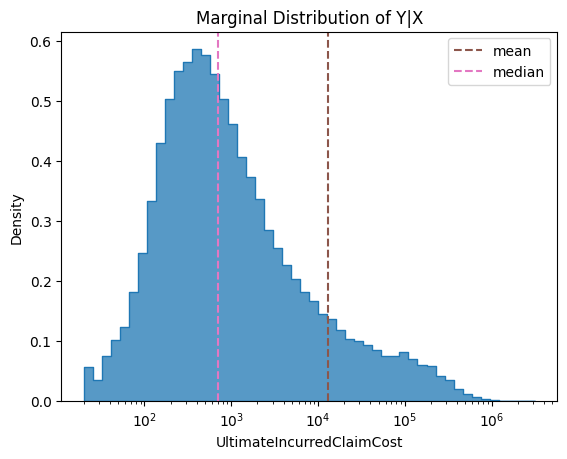

In [25]:
ax = sns.histplot(
    data=df,
    x=y_var,
    bins=50,
    log_scale=True,
    stat="density",
    element="step",
)
for i, (name, fun) in enumerate([("mean", np.mean), ("median", np.median)]):
    ax.axvline(
        x=fun(df[y_var]),
        ymin=0,
        ymax=1,
        color=f"C{i+5}",
        linestyle="--",
        label=name,
    )
ax.legend()
ax.set_title("Marginal Distribution of Y|X");

$$
\mathbb{E}\left[\mathbb{E}\left[Y | X \right]\right] = \mathbb{E}\left[Y \right]
$$

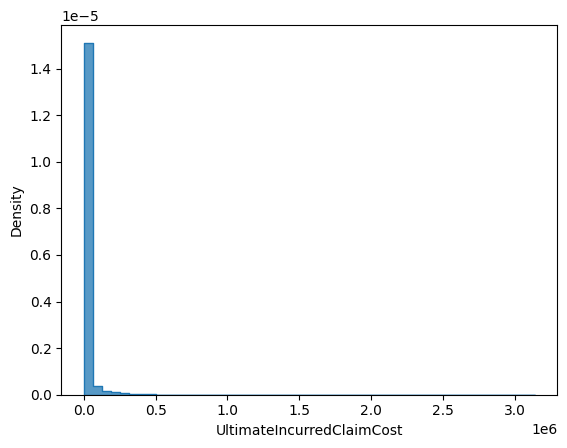

In [29]:
sns.histplot(
    data=df,
    x=y_var,
    bins=50,
    log_scale=False,
    stat="density",
    element="step"
);

#### 2.3.2 Univariate description

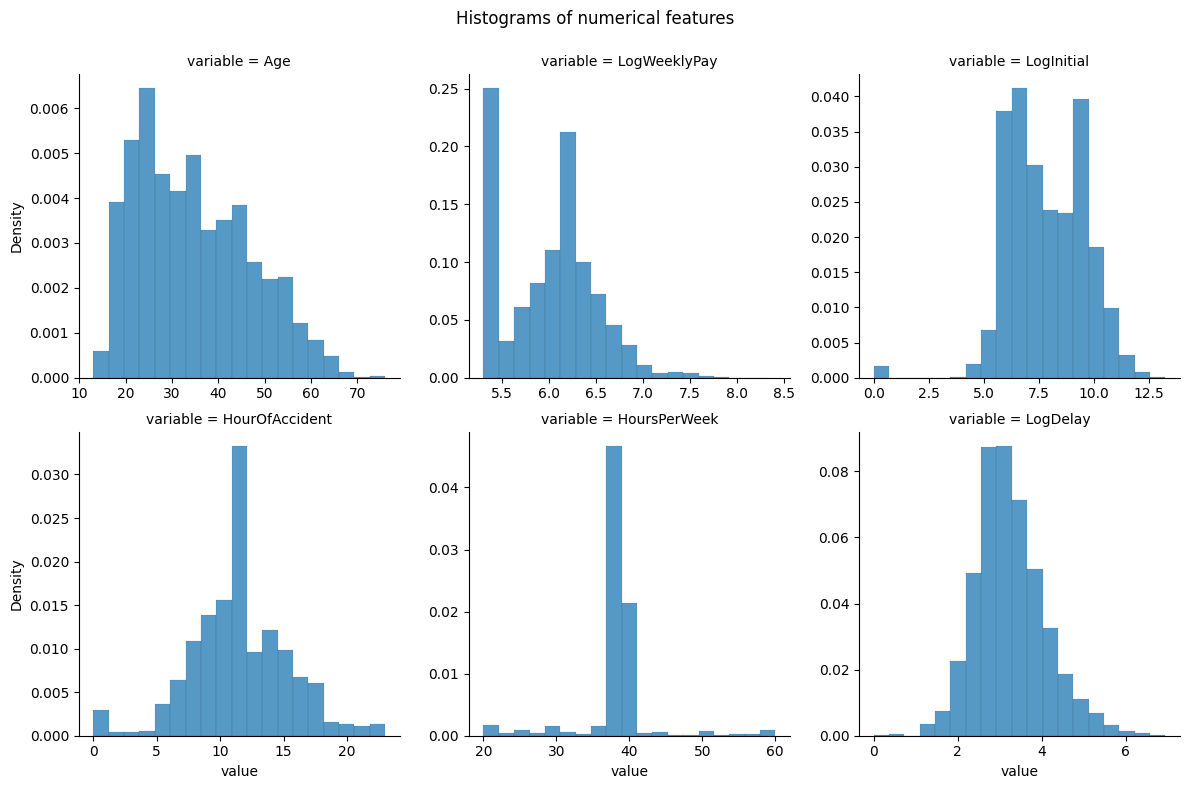

In [31]:
g = sns.displot(
    pd.melt(df.loc[:, x_continuous]),
    x="value",
    col="variable",
    stat="density",
    bins=19,
    common_bins=False,
    col_wrap=3,
    height=4,
    facet_kws={"sharex": False, "sharey": False},
)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Histograms of numerical features")
plt.show()

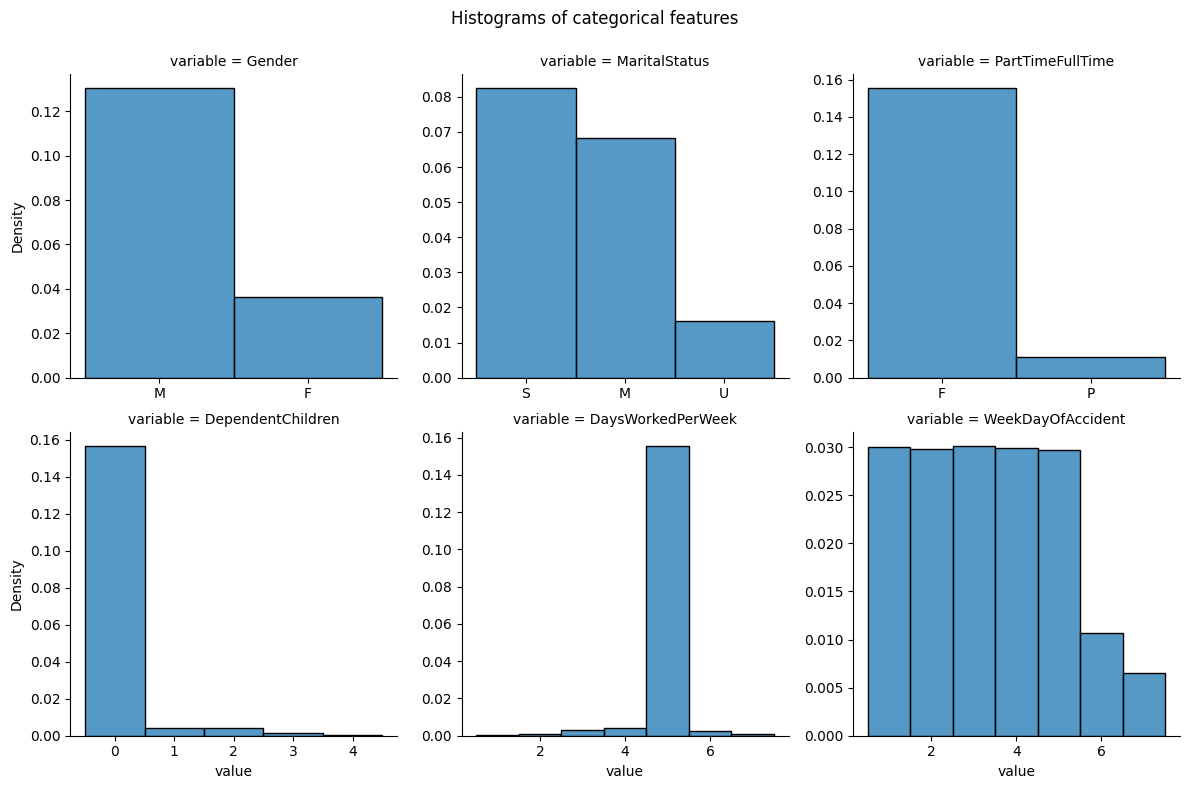

In [33]:
g = sns.displot(
    pd.melt(df.loc[:, x_discrete]),
    x="value",
    col="variable",
    stat="density",
    bins=19,
    common_bins=False,
    col_wrap=3,
    height=4,
    facet_kws={"sharex": False, "sharey": False},
)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Histograms of categorical features")
plt.show()

#### 2.3.3 Correlations across continuous covariates

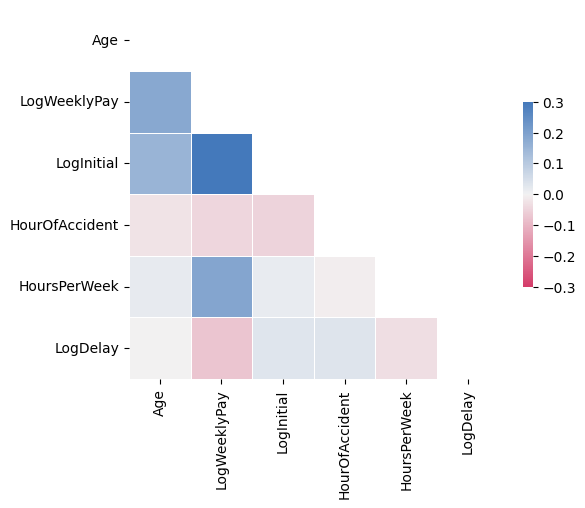

In [35]:
corr = df.loc[:, x_continuous].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-0.3,
    vmax=0.3,
    center=0,
    cmap=sns.diverging_palette(360, 250, as_cmap=True),
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

#### 2.3.4 Response in dependence of covariates

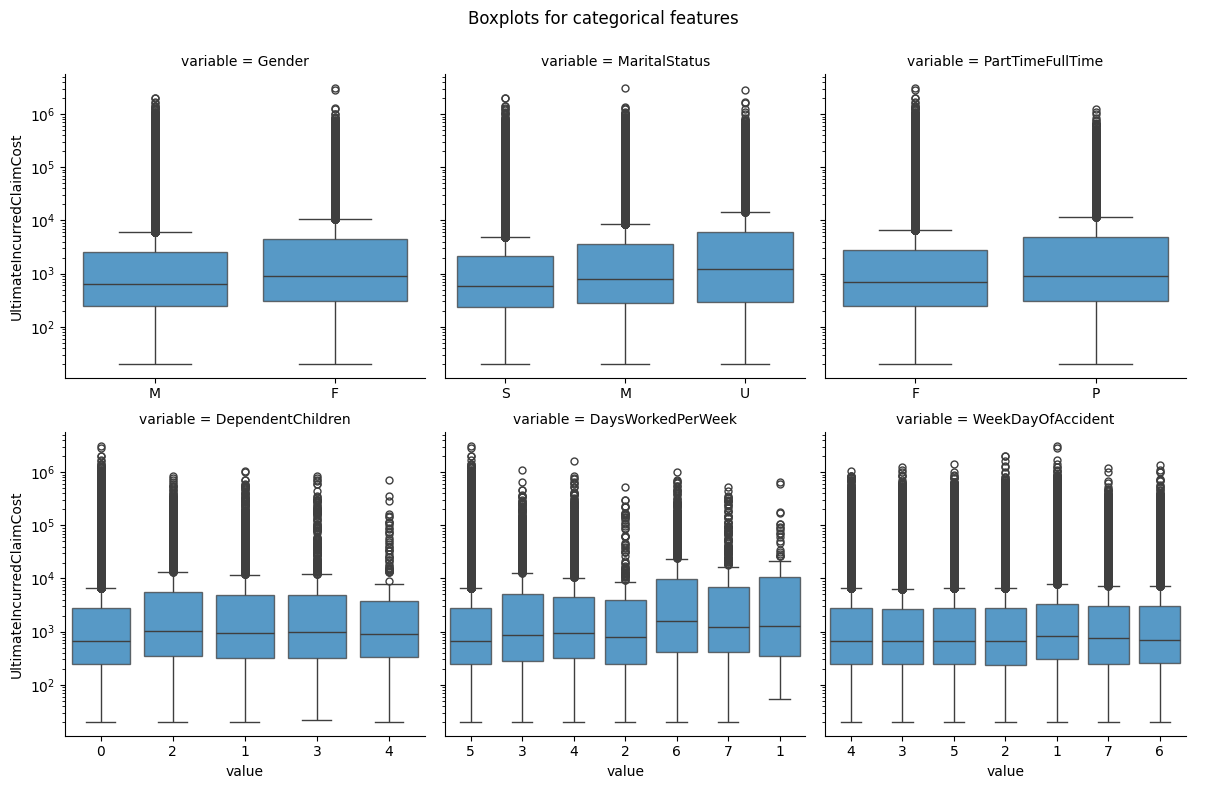

In [36]:
g = sns.catplot(
    data=pd.melt(df.loc[:, x_discrete + [y_var]], id_vars=y_var),
    x="value",
    y=y_var,
    col="variable",
    col_wrap=3,
    kind="box",
    sharex=False,
    height=4,
    color="C0",
    saturation=1,
    boxprops=dict(alpha=0.75),
)
g.set(yscale="log")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Boxplots for categorical features");

Text(0.5, 0.98, 'Heatmaps for numerical features')

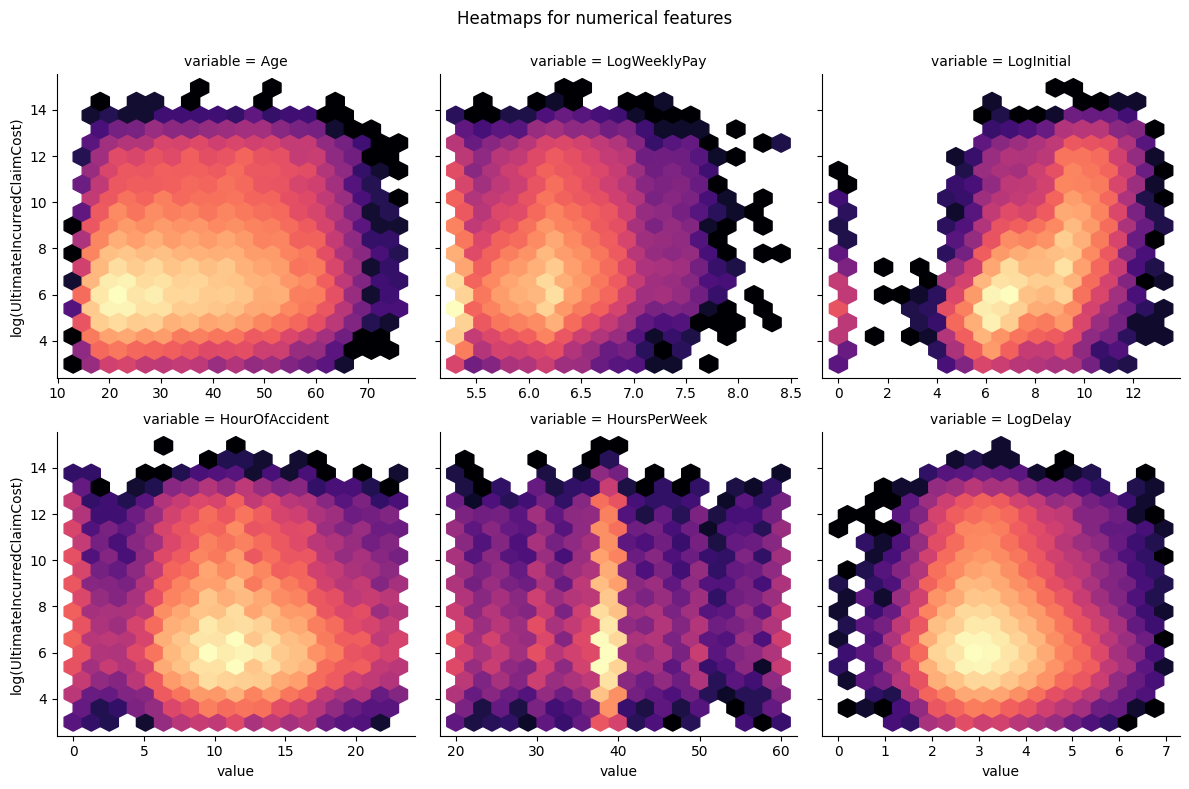

In [37]:
def hexbin(x, y, color, **kwargs):
    cmap = sns.color_palette(
        "magma",
        as_cmap=True,
    )  # sns.light_palette(color, as_cmap=True)
    plt.hexbin(x, y, gridsize=18, cmap=cmap, norm=LogNorm(), **kwargs)


# g = sns.FacetGrid(tips, hue="time", col="time", height=4)
# g.map(hexbin, "total_bill", "tip", extent=[0, 50, 0, 10]);
g = sns.FacetGrid(
    data=pd.melt(df.loc[:, x_continuous + [y_var]], id_vars=y_var).assign(
        **{"log(UltimateIncurredClaimCost)": lambda x: np.log(x[y_var])}
    ),
    col="variable",
    col_wrap=3,
    height=4,
    sharex=False,
)
g.map(hexbin, "value", "log(UltimateIncurredClaimCost)")
# g.set(yscale="log")
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Heatmaps for numerical features")

### 2.4 Data split

Next, we split our dataset into training and test data.

In [38]:
df_train, df_test = train_test_split(
    df,
    train_size=0.75,
    random_state=31415,
)
print(df_train.shape)
print(df_test.shape)

(61512, 13)
(20505, 13)


In [45]:
df_all = (
    pd.concat((df_train, df_test), axis=0, keys=("train", "test"))
    .reset_index(level=0)
    .rename(columns={"level_0": "dataset"})
)
df_all

,dataset,UltimateIncurredClaimCost,Age,LogWeeklyPay,LogInitial,HourOfAccident,HoursPerWeek,LogDelay,Gender,MaritalStatus,PartTimeFullTime,DependentChildren,DaysWorkedPerWeek,WeekDayOfAccident
12138,train,7562.41,47,6.216606,11.326596,14,38,3.912023,F,S,F,0,5,5
859,train,284.10,38,5.723585,10.596635,12,40,3.332205,F,M,F,3,5,5
58224,train,577.20,21,5.849325,9.159047,13,38,2.397895,M,S,F,0,5,1
6361,train,8884.74,26,6.093570,9.680344,12,38,3.806662,M,U,F,0,5,7
55389,train,228.45,46,5.303305,6.293419,10,40,3.496508,M,M,F,0,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49841,test,72.76,20,5.303305,9.210340,12,38,3.465736,F,S,F,0,5,5
51342,test,390.01,51,5.303305,9.159047,7,40,2.708050,M,M,F,2,5,4
71717,test,74.20,18,5.303305,6.214608,14,40,1.386294,M,S,F,0,5,2
62070,test,172.80,35,5.937536,5.991465,12,45,2.079442,M,M,F,1,5,1


In [46]:
y_train, y_test = df_train[y_var], df_test[y_var]
X_train, X_test = df_train[x_vars], df_test[x_vars]

We check whether the split results in two _about_ **identically distributed samples**.

In [52]:
(
    df_all.
    groupby('dataset').
    agg(
        mean=pd.NamedAgg(column=y_var, aggfunc='mean'),
        q10=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.1)),
        q20=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.2)),
        q40=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.4)),
        q50=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.5)),
        q60=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.6)),
        q80=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.8)),
        q90=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.9)),
        q95=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.95)),
        q99=pd.NamedAgg(column=y_var, aggfunc=lambda x: np.quantile(x, 0.99)),
    )
).style.format('{:,.2f}')


,mean,q10,q20,q40,q50,q60,q80,q90,q95,q99
dataset,,,,,,,,,,
test,"12,988.22",117.60,200.64,452.08,685.07,"1,094.53","4,589.79","19,261.57","63,827.01","263,597.25"
train,"13,013.75",119.13,204.40,464.00,697.18,"1,109.14","4,641.10","18,885.18","65,794.81","259,381.48"


### 2.5 The models
#### 2.5.1 Trivial (Null) Model

In [53]:
m_trivial = DummyRegressor(strategy="mean").fit(X_train, y_train)

When doing supervised learning, a simple sanity check consists of comparing one's estimator against simple rules of thumb?

'mean': always predicts the mean of the training set.


In [61]:
print(f'{m_trivial.predict(X_train).mean():,.2f}')

13,013.75


#### 2.5.2 OLS

Here, we train an Ordinary Least Squares (OLS) model, but on the log transformed target.
`TransformedTargetRegressor` takes care of this transformation and also of the back transformation such that predictions are on the original target UltimateIncurredClaimCost.

In [68]:
# ColumnTransformer for linear models
col_trans_linear = ColumnTransformer(
    [
        ("numeric_features", "passthrough", x_continuous),
        (
            "categorical_features",
            OneHotEncoder(drop="first", sparse_output=False),
            x_discrete,
        ),
    ],
    verbose_feature_names_out = False
)

m_ols = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        (
            "model",
            TransformedTargetRegressor(
                regressor=LinearRegression(),
                func=np.log,
                inverse_func=np.exp,
            ),
        ),
    ]
).fit(X_train, y_train)

In [78]:
stats_X_train = col_trans_linear.fit_transform(X_train)
stats_y_train = np.log(y_train)
stats_X_train.shape

(61512, 26)

In [80]:
stats_y_train.shape

(61512,)

<Axes: ylabel='Density'>

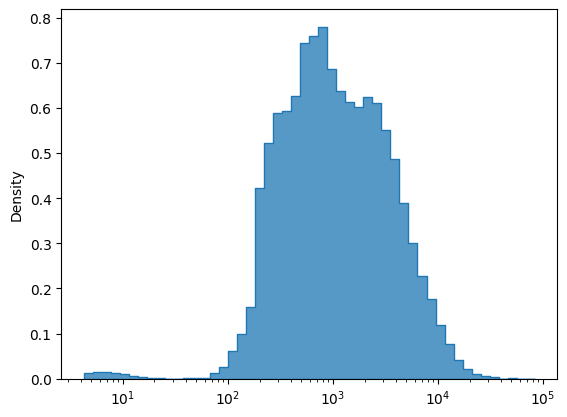

In [115]:
endog = stats_y_train
exog = sm.add_constant(stats_X_train)
sm_model = sm.OLS(endog, exog)
sm_results = sm_model.fit()
sns.histplot(
    np.exp(sm_results.predict(exog)),
    bins=50,
    log_scale=True,
    stat="density",
    element="step",
)

In [116]:
sm_results.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     UltimateIncurredClaimCost   R-squared:                       0.347
Model:                                   OLS   Adj. R-squared:                  0.347
No. Observations:                      61512   F-statistic:                     1259.
Covariance Type:                   nonrobust   Prob (F-statistic):               0.00
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.4159      0.215     -6.588      0.000      -1.837      -0.995
Age                     0.0116      0.001     18.886      0.000       0.010       0.013
LogWeeklyPay            0.5652      0.014     39.768      0.000       0.537       0.593
LogInitial              0.5997      0.004    145.291      0.000       0.592       0.608
HourOfAccident         -0.0027      0.002     -1.586      0.113      -0.006       0.001
HoursPerWeek           -0.0007      0.002     -0.437      0.662      -0.004       0.002
LogDelay                0.0291      0.008      3.730      0.000       0.014       0.044
Gender_M               -0.2050      0.016    -12.465      0.000      -0.237      -0.173
MaritalStatus_S        -0.0852      0.016     -5.364      0.000      -0.116      -0.054
MaritalStatus_U        -0.1872      0.024     -7.739      0.000      -0.235      -0.140
PartTimeFullTime_P      0.1507      0.037      4.112      0.000       0.079       0.223
DependentChildren_1    -0.0380      0.044     -0.870      0.384      -0.123       0.048
DependentChildren_2     0.0578      0.042      1.388      0.165      -0.024       0.139
DependentChildren_3     0.0216      0.066      0.327      0.744      -0.108       0.151
DependentChildren_4    -0.0333      0.118     -0.283      0.777      -0.264       0.198
DaysWorkedPerWeek_2     0.0407      0.212      0.192      0.848      -0.375       0.456
DaysWorkedPerWeek_3     0.0653      0.193      0.338      0.735      -0.313       0.444
DaysWorkedPerWeek_4     0.1013      0.192      0.529      0.597      -0.274       0.477
DaysWorkedPerWeek_5     0.1631      0.189      0.863      0.388      -0.207       0.534
DaysWorkedPerWeek_6     0.2185      0.197      1.112      0.266      -0.167       0.604
DaysWorkedPerWeek_7     0.0308      0.205      0.151      0.880      -0.370       0.432
WeekDayOfAccident_2    -0.2126      0.022     -9.788      0.000      -0.255      -0.170
WeekDayOfAccident_3    -0.1968      0.022     -9.123      0.000      -0.239      -0.155
WeekDayOfAccident_4    -0.1800      0.022     -8.321      0.000      -0.222      -0.138
WeekDayOfAccident_5    -0.1826      0.022     -8.421      0.000      -0.225      -0.140
WeekDayOfAccident_6    -0.1591      0.030     -5.322      0.000      -0.218      -0.101
WeekDayOfAccident_7    -0.1750      0.036     -4.845      0.000      -0.246      -0.104
=======================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [65]:
m_ols

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  'passthrough',
                                                  ['Age', 'LogWeeklyPay',
                                                   'LogInitial',
                                                   'HourOfAccident',
                                                   'HoursPerWeek',
                                                   'LogDelay']),
                                                 ('categorical_features',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Gender', 'MaritalStatus',
                                                   'PartTimeFullTime',
                                                   'DependentChildren',
                                                   'DaysWorkedPerWeek',
                                                   'WeekDayOfAccident'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

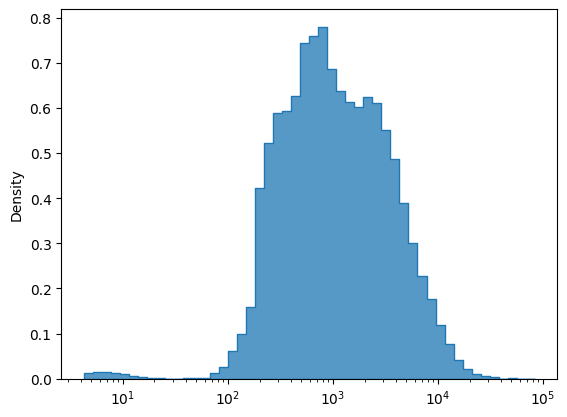

In [123]:

sns.histplot(
    m_ols.predict(X_train),
    bins=50,
    log_scale=True,
    stat="density",
    element="step",
);

We expect a high bias due to the transformation. We correct for this bias by a multiplicative constant such that on the training set: $\sum_i m(x_i) = \sum_i y_i$.

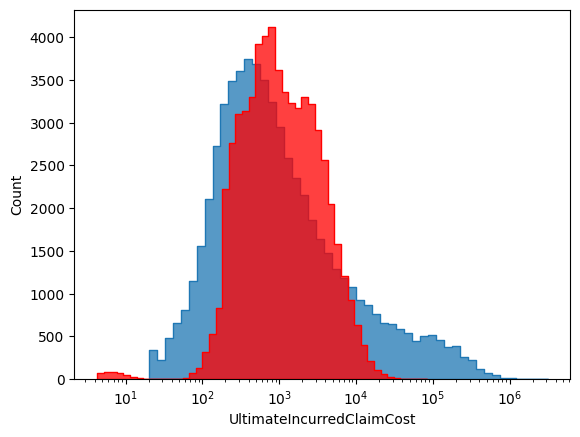

In [131]:
_, ax = plt.subplots()
sns.histplot(
    y_train,
    bins=50,
    log_scale=True,
#    stat="density",
    element="step",
    ax=ax
)
sns.histplot(
    m_ols.predict(X_train),
    bins=50,
    log_scale=True,
#    stat="density",
    element="step",
    color='red',
    ax=ax
);


In [134]:
ols_corr_factor = np.sum(y_train) / np.sum(m_ols.predict(X_train))
print(f"The correction factor is {ols_corr_factor:.5f}")

The correction factor is 6.62475


In [ ]:

m_ols_corr = deepcopy(m_ols)
m_ols_corr[-1].regressor_.intercept_ += np.log(ols_corr_factor)

In [135]:
print(f'Sum of ground truth: {np.sum(y_train):,.2f}')
print(f'Sum of prediction: {np.sum(m_ols.predict(X_train)):,.2f}')

Sum of ground truth: 800,501,884.48
Sum of prediction: 120,835,102.84


In [139]:
m_ols_corrected = deepcopy(m_ols)

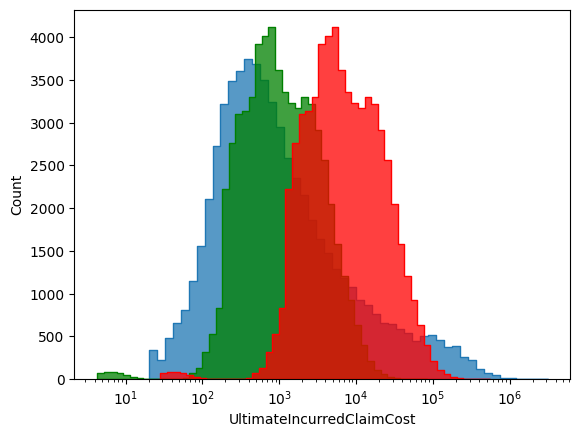

In [140]:
m_ols_corrected[-1].regressor_.intercept_ += np.log(ols_corr_factor)
_, ax = plt.subplots()
sns.histplot(
    y_train,
    bins=50,
    log_scale=True,
    element="step",
    ax=ax
)
sns.histplot(
    m_ols.predict(X_train),
    bins=50,
    log_scale=True,
    element="step",
    color='green',
    ax=ax
)
sns.histplot(
    m_ols_corrected.predict(X_train),
    bins=50,
    log_scale=True,
    element="step",
    color='red',
    ax=ax
);

In [118]:
np.log(6.62475)

1.8908126353112142

In [ ]:
np.sum(y_train) / np.sum(m_ols_corr.predict(X_train))

0.9999999999999997

#### 2.5.3 Gamma GLM

In [ ]:
m_glm_gamma = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        ("model", GammaRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train)

As the Gamma GLM with log-link does not have a canonical loss-link combination, it does not fulfil the balance property and is likely biased.
Therefore, we perform the same bias correction as with OLS model.

In [ ]:
glm_gamma_corr_factor = np.sum(y_train) / np.sum(m_glm_gamma.predict(X_train))
print(f"The correction factor is {glm_gamma_corr_factor}")

m_glm_gamma_corr = deepcopy(m_glm_gamma)
m_glm_gamma_corr[-1].intercept_ += np.log(glm_gamma_corr_factor)

print(
    "Check for balance property (should be close to 1): "
    f"{np.sum(y_train) / np.sum(m_glm_gamma_corr.predict(X_train))}"
)

The correction factor is 1.1130770461759643
Check for balance property (should be close to 1): 0.9999999999999994


#### 2.5.4 Poisson GLM
Note that the Poisson GLM has a canonical loss-link combination that ensures good calibration (given the design matrix is well specified).

In [ ]:
m_glm_poisson = Pipeline(
    [
        ("column_transformer", col_trans_linear),
        ("model", PoissonRegressor(alpha=1e-15, solver="newton-cholesky")),
    ]
).fit(X_train, y_train)

#### 2.5.5 Gradient boosted trees
Resonable choices for XGBoost's hyperparameters are provided in the grid search table stored as "grid/grid_xgb_py.csv".
Thus, there is no need for retuning those parameters.

In [ ]:
%%time

# Data interface
dtrain = xgboost.DMatrix(
    data=X_train,
    label=y_train,
    enable_categorical=True,
)

# Settings
tune = False  # If set to True, it may take ~1h.
file_grid = "grid/grid_xgb_py.csv"

if tune:
    # Step 1: find good learning rate
    xgboost.cv(
        params=dict(
            learning_rate=0.03,
            tree_method="hist",
            objective="reg:gamma",
        ),
        dtrain=dtrain,
        num_boost_round=5000,
        nfold=5,
        show_stdv=False,
        early_stopping_rounds=20,
        verbose_eval=2,
    )

    # Step 2: Grid search CV on typical parameter combos
    paramGrid = dict(
        iteration=[np.nan],
        score=[np.nan],
        learning_rate=[0.03],
        max_depth=range(4, 7),
        min_child_weight=[0, 1e-04],
        colsample_bynode=[0.8, 1],
        subsample=[0.8, 1],
        reg_lambda=range(0, 3),
        reg_alpha=range(0, 3),
        objective=["reg:gamma"],
        tree_method=["hist"],
        eval_metric=["gamma-nloglik"],
    )
    paramGrid = pd.DataFrame.from_records(
        itertools.product(*paramGrid.values()),
        columns=paramGrid.keys(),
    )
    for i in progress_bar(range(paramGrid.shape[0])):
        cvm = xgboost.cv(
            paramGrid.iloc[i, 2:].to_dict(),
            dtrain,
            num_boost_round=5000,
            nfold=5,
            show_stdv=False,
            early_stopping_rounds=20,
            seed=0,
            verbose_eval=0,
        )
        paramGrid.iloc[i, 0] = (bi := cvm["test-gamma-nloglik-mean"].argmin()) + 1
        paramGrid.iloc[i, 1] = cvm.loc[bi, "test-gamma-nloglik-mean"]
    paramGrid.sort_values("score", ascending=True).to_csv(file_grid, index=False)
paramGrid = pd.read_csv(file_grid)

CPU times: user 88.6 ms, sys: 23.6 ms, total: 112 ms
Wall time: 27.3 ms


In [ ]:
paramGrid.iloc[0]

iteration                   394.0
score                    9.736303
learning_rate                0.03
max_depth                       4
min_child_weight           0.0001
colsample_bynode              0.8
subsample                     1.0
reg_lambda                      2
reg_alpha                       2
objective               reg:gamma
tree_method                  hist
eval_metric         gamma-nloglik
Name: 0, dtype: object

In [ ]:
# Step 3: Fit on best params
m_xgb = xgboost.train(
    params=paramGrid.iloc[0, 2:].to_dict() | {"seed": 31415},
    dtrain=dtrain,
    num_boost_round=int(paramGrid.iloc[0, 0]),
)


# Predict wrapper for xgb model
def m_xgb_predict(X):
    dmat = xgboost.DMatrix(X, enable_categorical=True)
    return m_xgb.predict(dmat)


# Same with bias correction
corr_fact_xgb = np.mean(y_train) / np.mean(m_xgb_predict(X_train))


def m_xgb_corr_predict(X):
    return corr_fact_xgb * m_xgb_predict(X)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

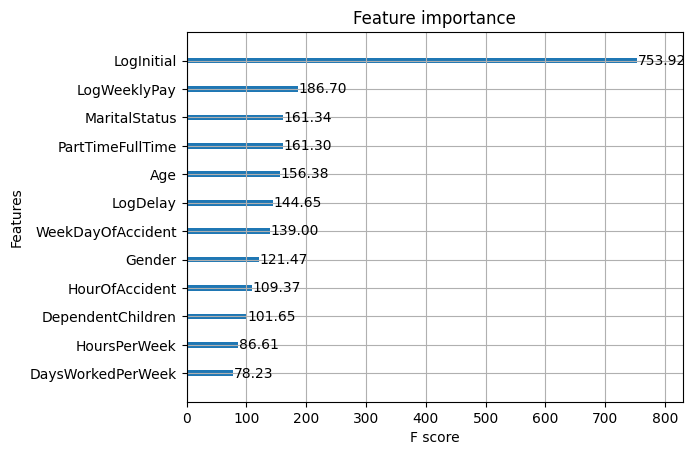

In [ ]:
# feature importance, helps to select features for calibration analysis
xgboost.plot_importance(m_xgb, importance_type="gain", values_format="{v:.2f}")

### 2.6 Calibration assessment
#### 2.6.1 Unconditional calibration in terms of bias

In [ ]:
model_levels = [
    "trivial",
    "ols",
    "ols_corr",
    "glm_gamma",
    "glm_gamma_corr",
    "glm_poisson",
    "xgb",
    "xgb_corr",
]

df_cali = df_all.copy()
df_cali["prediction_trivial"] = m_trivial.predict(df_all[x_vars])
df_cali["prediction_ols"] = m_ols.predict(df_all[x_vars])
df_cali["prediction_ols_corr"] = m_ols_corr.predict(df_all[x_vars])
df_cali["prediction_glm_gamma"] = m_glm_gamma.predict(df_all[x_vars])
df_cali["prediction_glm_gamma_corr"] = m_glm_gamma_corr.predict(df_all[x_vars])
df_cali["prediction_glm_poisson"] = m_glm_poisson.predict(df_all[x_vars])
df_cali["prediction_xgb"] = m_xgb_predict(df_all[x_vars])
df_cali["prediction_xgb_corr"] = m_xgb_corr_predict(df_all[x_vars])

In [ ]:
# Unconditional calibration
compute_bias(
    y_obs=df_cali[y_var],
    y_pred=df_cali.loc[:, df_cali.columns.str.startswith("prediction_")],
    feature=df_cali["dataset"],
).with_columns(pl.col("model").str.extract("_(\w+)", 1))

model,dataset,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,str,f64,u32,f64,f64,f64
"""trivial""","""test""",25.531554,20505,20505.0,376.582193,0.945947
"""trivial""","""train""",-7.8360e-11,61512,61512.0,229.859381,1.0
"""ols""","""test""",-11024.114099,20505,20505.0,370.667261,2.4482e-190
"""ols""","""train""",-11049.336416,61512,61512.0,226.814431,0.0
"""ols_corr""","""test""",23.482945,20505,20505.0,354.684569,0.947213
"""ols_corr""","""train""",3.9443e-12,61512,61512.0,218.978845,1.0
"""glm_gamma""","""test""",-1250.257224,20505,20505.0,357.704339,0.000475
"""glm_gamma""","""train""",-1322.061746,61512,61512.0,220.049248,1.8885e-9
"""glm_gamma_corr…","""test""",77.036933,20505,20505.0,357.703452,0.829485


#### 2.6.2 Auto-calibration

Visualized differently on train and test.

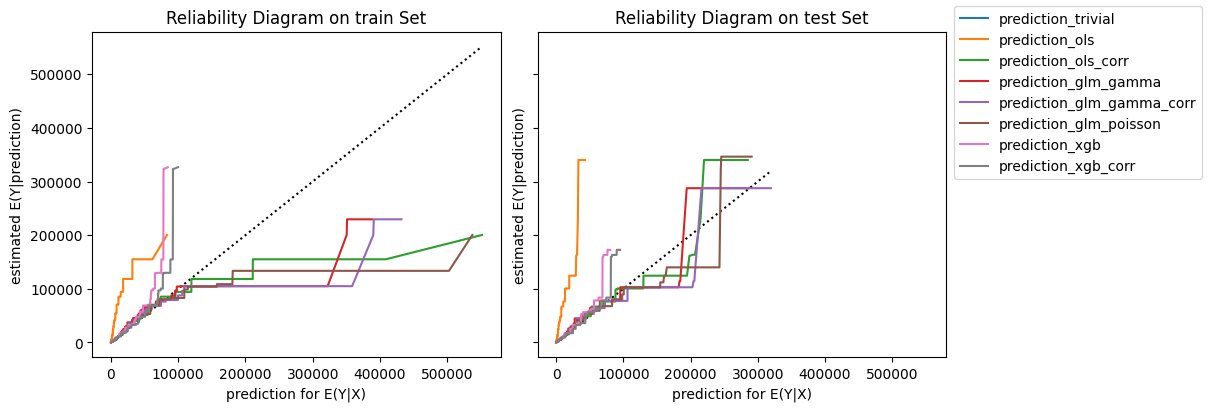

In [ ]:
fig, axes = plt.subplots(
    ncols=2, figsize=(8 + 4, 4), layout="constrained", sharey=True, sharex=True
)
for i, dataset in enumerate(["train", "test"]):
    plot_reliability_diagram(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'").loc[
            :, df_cali.columns.str.startswith("prediction_")
        ],
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Reliability Diagram on {dataset} Set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

Lines below the diagonal means that the predictions are too high, values above the diagonal that predictions are too small.

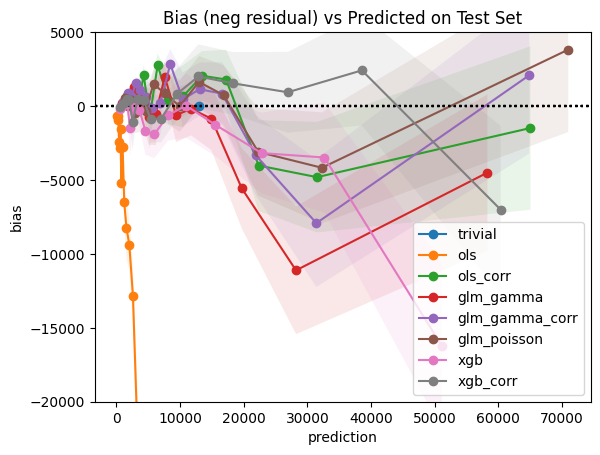

In [ ]:
# We use the plot_bias function, but we must loop over it, because
# we want to set feature=y_pred which is different for every model.
fig, ax = plt.subplots()
for i, model in enumerate(model_levels):
    plot_bias(
        y_obs=df_cali.query("dataset=='test'")[y_var],
        y_pred=df_cali.query("dataset=='test'")[f"prediction_{model}"],
        feature=df_cali.query("dataset=='test'")[f"prediction_{model}"],
        n_bins=15,
        ax=ax,
    )
    ax.lines[-1].set_label(model)
ax.set_xlabel("prediction")
ax.set_title("Bias (neg residual) vs Predicted on Test Set")
ax.set_ylim(-2e4, 0.5e4)
ax.legend()

In [ ]:
# Table for test function phi = prediction
# First, we convert to a long table.
df_cali_long = pd.melt(
    frame=df_cali,
    id_vars=["dataset", y_var] + x_vars,
    value_vars=["prediction_" + m for m in model_levels],
    var_name="model",
    value_name="prediction",
)
df_cali_long["model"] = pd.Categorical(
    values=df_cali_long["model"].str.removeprefix("prediction_"),
    categories=model_levels,
)

# Test value is phi * V = y_pred * (y_pred - y_obs)
df_cali_long["bias_test"] = df_cali_long["prediction"] * identification_function(
    y_obs=df_cali_long[y_var], y_pred=df_cali_long["prediction"]
)
df_cali_long.groupby(["dataset", "model"], observed=True).agg(
    bias_test=("bias_test", "mean")
).unstack(0)

bias_test              
dataset                 test         train
model                                     
trivial         3.322613e+05  1.558188e-08
ols            -6.331526e+07 -6.089994e+07
ols_corr       -3.654297e+06  6.592958e+06
glm_gamma      -2.916415e+07 -2.687501e+07
glm_gamma_corr  1.700539e+07  1.858736e+07
glm_poisson     3.565341e+07  4.251958e+07
xgb            -7.629522e+07 -8.622279e+07
xgb_corr       -2.164528e+07 -3.358370e+07

#### 2.6.3 Calibration conditional on Gender

In [ ]:
compute_bias(
    y_obs=df_cali.query("dataset=='train'")[y_var],
    y_pred=df_cali.query("dataset=='train'")[
        [col for col in df_cali if col.startswith("prediction_")]
    ],
    feature=df_cali.query("dataset=='train'")["Gender"],
)

model,Gender,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""prediction_tri…","""F""",-4318.448712,13547,13547.0,586.026761,1.8182e-13
"""prediction_tri…","""M""",1219.681532,47965,47965.0,243.641243,5.5753e-7
"""prediction_ols…","""F""",-14856.17284,13547,13547.0,579.744579,1.8171e-141
"""prediction_ols…","""M""",-9974.152156,47965,47965.0,240.186705,0.0
"""prediction_ols…","""F""",-929.147163,13547,13547.0,565.077502,0.100141
"""prediction_ols…","""M""",262.42378,47965,47965.0,231.056463,0.256064
"""prediction_glm…","""F""",-1081.846783,13547,13547.0,566.884792,0.05636
"""prediction_glm…","""M""",-1389.906885,47965,47965.0,232.385179,2.2327e-9
"""prediction_glm…","""F""",755.695186,13547,13547.0,567.864568,0.183288


In [ ]:
compute_bias(
    y_obs=df_cali.query("dataset=='test'")[y_var],
    y_pred=df_cali.query("dataset=='test'")[
        [col for col in df_cali if col.startswith("prediction_")]
    ],
    feature=df_cali.query("dataset=='test'")["Gender"],
)

model,Gender,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,cat,f64,u32,f64,f64,f64
"""prediction_tri…","""F""",-4575.615427,4382,4382.0,932.21244,9.5189e-7
"""prediction_tri…","""M""",1276.057266,16123,16123.0,405.885733,0.00167
"""prediction_ols…","""F""",-15068.060981,4382,4382.0,919.635048,1.3160e-58
"""prediction_ols…","""M""",-9925.027375,16123,16123.0,399.27138,6.9725e-134
"""prediction_ols…","""F""",-886.354825,4382,4382.0,891.389676,0.320107
"""prediction_ols…","""M""",270.763793,16123,16123.0,380.49584,0.476718
"""prediction_glm…","""F""",-1091.627691,4382,4382.0,898.827635,0.224622
"""prediction_glm…","""M""",-1293.370454,16123,16123.0,383.784357,0.000753
"""prediction_glm…","""F""",773.887934,4382,4382.0,901.1787,0.390525


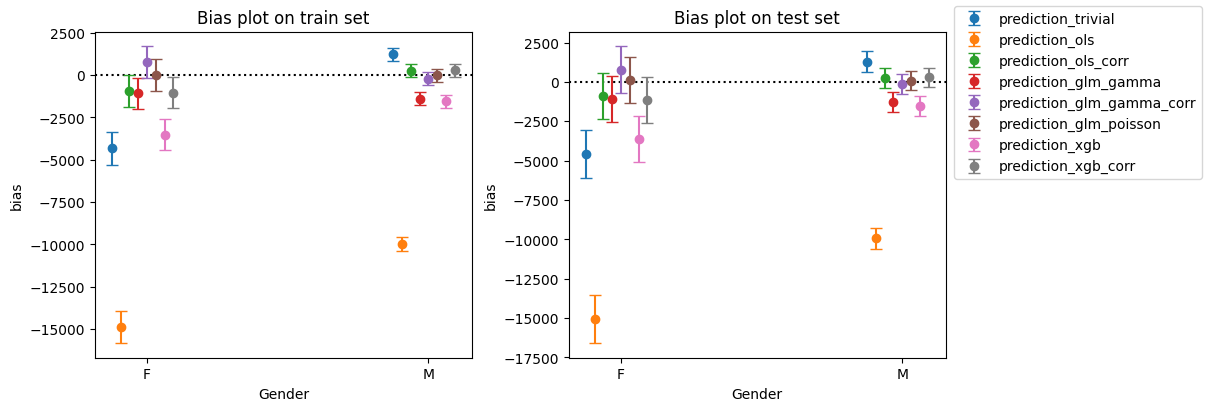

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8 + 4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_bias(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [col for col in df_cali if col.startswith("prediction_")]
        ],
        feature=df_cali.query(f"dataset=='{dataset}'")["Gender"],
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Bias plot on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

#### 2.6.4 Calibration conditional on LogWeeklyPay

LogWeeklyPay is the second most important feature after the initial claim reserve estimate.

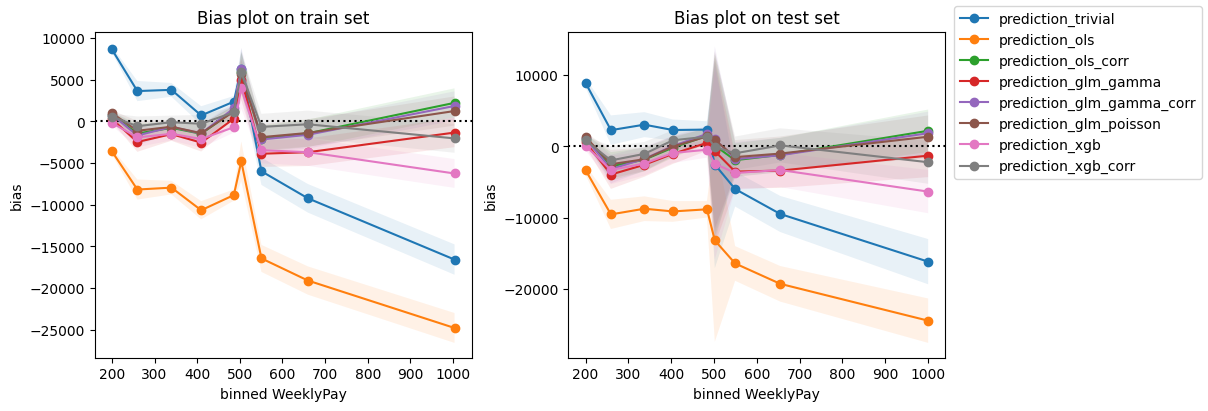

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8 + 4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_bias(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [col for col in df_cali if col.startswith("prediction_")]
        ],
        feature=pd.Series(
            data=np.exp(df_cali.query(f"dataset=='{dataset}'")["LogWeeklyPay"]) - 1,
            name="WeeklyPay",
        ),
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Bias plot on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

In [ ]:
# Test function = LogWeeklyPay on test set
results = []
for i, dataset in enumerate(["train", "test"]):
    phi = df_cali.query(f"dataset=='{dataset}'")["LogWeeklyPay"]
    results.append(
        compute_bias(
            y_obs=phi * df_cali.query(f"dataset=='{dataset}'")[y_var],
            y_pred=df_cali.query(f"dataset=='{dataset}'")[
                [col for col in df_cali if col.startswith("prediction_")]
            ].multiply(phi, axis="index"),
        ).with_columns(dataset=pl.lit(dataset))
    )
with pl.Config(fmt_str_lengths=50):
    display(
        pl.concat(results).select(
            pl.col("model", "dataset"), cs.all() - cs.by_name("model", "dataset")
        )
    )

model,dataset,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,str,f64,u32,f64,f64,f64
"""prediction_trivial""","""train""",-3625.267973,61512,61512.0,1459.440315,0.012994
"""prediction_ols""","""train""",-69333.401818,61512,61512.0,1441.968457,0.0
"""prediction_ols_corr""","""train""",171.049746,61512,61512.0,1389.763778,0.902046
"""prediction_glm_gamma""","""train""",-8184.354304,61512,61512.0,1396.514731,4.6366e-9
"""prediction_glm_gamma_corr""","""train""",127.481632,61512,61512.0,1396.971548,0.92729
"""prediction_glm_poisson""","""train""",7.8349e-10,61512,61512.0,1392.008753,1.0
"""prediction_xgb""","""train""",-12717.458459,61512,61512.0,1383.309855,3.9172e-20
"""prediction_xgb_corr""","""train""",-277.01686,61512,61512.0,1379.018456,0.840793
"""prediction_trivial""","""test""",-3519.901907,20505,20505.0,2394.251593,0.141537


### 2.7 Model comparison
#### 2.7.1 Compare absolute and relative performance scores

In [ ]:
results = []
for i, dataset in enumerate(["train", "test"]):
    results.append(
        decompose(
            y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
            y_pred=df_cali.query(f"dataset=='{dataset}'")[
                [col for col in df_cali if col.startswith("prediction_")]
            ],
            scoring_function=GammaDeviance(),
        ).with_columns(dataset=pl.lit(dataset))
    )
with pl.Config(fmt_str_lengths=50):
    display(
        df_perf := pl.concat(results).select(
            pl.col("model", "dataset"), cs.all() - cs.by_name("model", "dataset")
        )
    )

model,dataset,miscalibration,discrimination,uncertainty,score
str,str,f64,f64,f64,f64
"""prediction_trivial""","""train""",0.0,0.0,5.062198,5.062198
"""prediction_ols""","""train""",7.780028,1.537915,5.062198,11.30431
"""prediction_ols_corr""","""train""",0.265616,1.537915,5.062198,3.789899
"""prediction_glm_gamma""","""train""",0.15914,1.569904,5.062198,3.651434
"""prediction_glm_gamma_corr""","""train""",0.170217,1.569904,5.062198,3.662511
"""prediction_glm_poisson""","""train""",0.38481,1.570608,5.062198,3.8764
"""prediction_xgb""","""train""",0.056569,1.876068,5.062198,3.242699
"""prediction_xgb_corr""","""train""",0.072155,1.876068,5.062198,3.258285
"""prediction_trivial""","""test""",0.000004,-1.7764e-15,5.093423,5.093427


Text(0.5, 1.0, 'Mean Gamma Deviance')

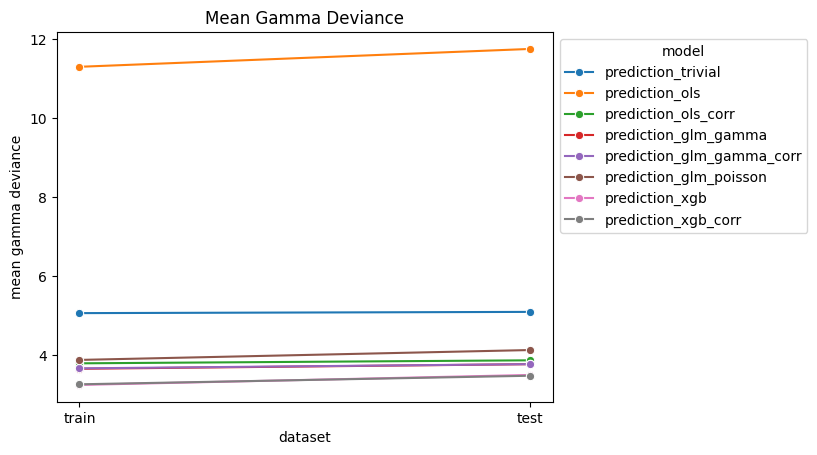

In [ ]:
ax = sns.lineplot(data=df_perf, x="dataset", y="score", hue="model", marker="o")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel("mean gamma deviance")
ax.set_title("Mean Gamma Deviance")

#### 2.7.2 Murphy diagram (for elementary score)

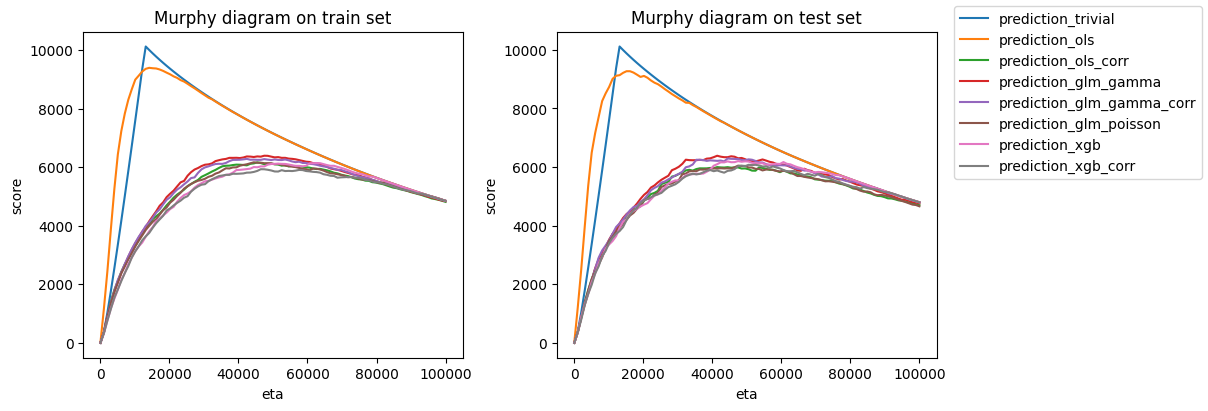

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8 + 4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_murphy_diagram(
        y_obs=df_cali.query(f"dataset=='{dataset}'")[y_var],
        y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [
                col
                for col in df_cali
                if col.startswith("prediction_") and col not in {"trivial", "ols"}
            ]
        ],
        etas=np.linspace(0, 1e5, 100),
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Murphy diagram on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

## 3. Binary Classification Example

The classification example is based on the “Telco Customer Churn” dataset on OpenML. We will model churn probability as a function of a couple of features.

### 3.1 Attach all packages and fetch data

The dataset is being downloaded.

In [ ]:
from importlib.metadata import version
import sys

print(f"Python version {sys.version[0:6]}")
print("\nPackage versions:")
for lib in [
    "matplotlib",
    "model_diagnostics",
    "numpy",
    "pandas",
    "polars",
    "seaborn",
    "scikit-learn",
    "xgboost",
]:
    print(lib + " " + version(lib))

Python version 3.11.7

Package versions:
matplotlib 3.8.2
model_diagnostics 1.0.4
numpy 1.26.3
pandas 2.1.4
polars 0.20.2
seaborn 0.13.1
scikit-learn 1.4.0
xgboost 2.0.3


In [ ]:
from copy import deepcopy
import itertools

from fastprogress.fastprogress import progress_bar
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias
from model_diagnostics.calibration import identification_function
from model_diagnostics.calibration import plot_bias
from model_diagnostics.calibration import plot_reliability_diagram
from model_diagnostics.scoring import LogLoss, decompose
from model_diagnostics.scoring import plot_murphy_diagram
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import seaborn as sns
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import SplineTransformer
import xgboost


set_config(transform_output="pandas")  # needs scikit-learn >= 1.2.0

# Telco customer churn dataset, see # https://www.openml.org/d/42178
df_original = fetch_openml(data_id=42178, parser="auto").frame
# df_original is a pandas.DataFrame

### 3.2 Data preparation

In [ ]:
df = df_original.copy()
y_var = "Churn"
x_continuous = ["tenure", "MonthlyCharges", "LogTotalCharges"]
x_discrete = sorted(
    list(
        set(df_original.columns)
        - set(x_continuous)
        - set([y_var, "customerID", "TotalCharges"])
    )
)
x_vars = x_continuous + x_discrete

df.loc[
    df["MultipleLines"].isin(["No internet service", "No phone service"]),
    "MultipleLines",
] = "No"
df = df.assign(
    # errors="coerce" sets value that cannot be parsed/converted to NaN
    LogTotalCharges=lambda x: np.log(pd.to_numeric(x["TotalCharges"], errors="coerce")),
    **{col: df[col].astype("category") for col in x_discrete},
)

df = df.loc[:, [y_var] + x_vars]

# We do not leak any information by the label encoder.
# This is later used when we need numerical target values in {0, 1}.
# "No" -> 0, "Yes" -> 1
le = LabelEncoder().fit(["No", "Yes"])

print(f"The prepared dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")
df.head(10)

The prepared dataset contains 7043 rows and 20 columns.


,Churn,tenure,MonthlyCharges,LogTotalCharges,Contract,Dependents,DeviceProtection,InternetService,MultipleLines,OnlineBackup,OnlineSecurity,PaperlessBilling,Partner,PaymentMethod,PhoneService,SeniorCitizen,StreamingMovies,StreamingTV,TechSupport,gender
0,No,1,29.85,3.396185,Month-to-month,No,No,DSL,'No phone service',Yes,No,Yes,Yes,'Electronic check',No,0,No,No,No,Female
1,No,34,56.95,7.544068,'One year',No,Yes,DSL,No,No,Yes,No,No,'Mailed check',Yes,0,No,No,No,Male
2,Yes,2,53.85,4.683519,Month-to-month,No,No,DSL,No,Yes,Yes,Yes,No,'Mailed check',Yes,0,No,No,No,Male
3,No,45,42.30,7.517928,'One year',No,Yes,DSL,'No phone service',No,Yes,No,No,'Bank transfer (automatic)',No,0,No,No,Yes,Male
4,Yes,2,70.70,5.021575,Month-to-month,No,No,'Fiber optic',No,No,No,Yes,No,'Electronic check',Yes,0,No,No,No,Female
5,Yes,8,99.65,6.709914,Month-to-month,No,Yes,'Fiber optic',Yes,No,No,Yes,No,'Electronic check',Yes,0,Yes,Yes,No,Female
6,No,22,89.10,7.575277,Month-to-month,Yes,No,'Fiber optic',Yes,Yes,No,Yes,No,'Credit card (automatic)',Yes,0,No,Yes,No,Male
7,No,10,29.75,5.710096,Month-to-month,No,No,DSL,'No phone service',No,Yes,No,No,'Mailed check',No,0,No,No,No,Female
8,Yes,28,104.80,8.021601,Month-to-month,No,Yes,'Fiber optic',Yes,No,No,Yes,Yes,'Electronic check',Yes,0,Yes,Yes,Yes,Female
9,No,62,56.15,8.157069,'One year',Yes,No,DSL,No,Yes,Yes,No,No,'Bank transfer (automatic)',Yes,0,No,No,No,Male


### 3.3 Exploratory data analysis
#### 3.3.1 Univariate description of target

In [ ]:
df[y_var].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

#### 3.3.2 Univariate description

Text(0.5, 0.98, 'Histograms of numerical features')

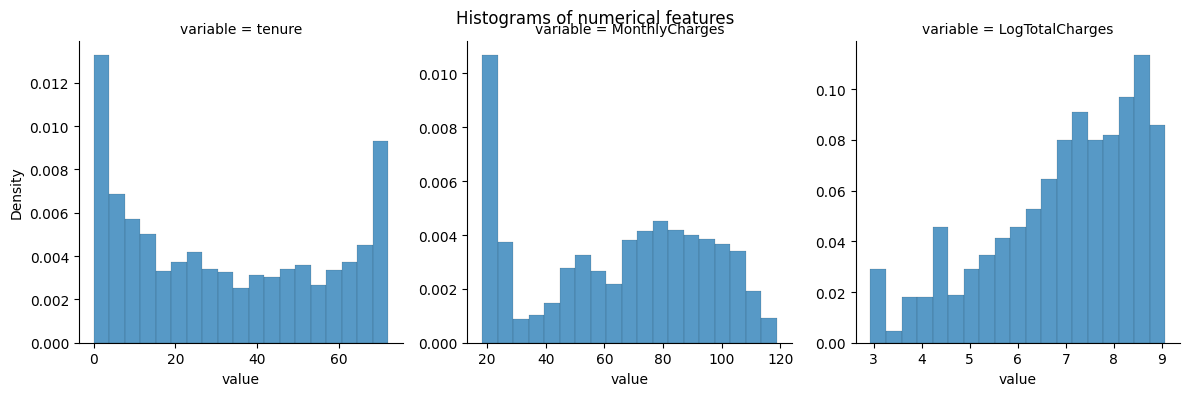

In [ ]:
g = sns.displot(
    pd.melt(df.loc[:, x_continuous]),
    x="value",
    col="variable",
    stat="density",
    bins=19,
    common_bins=False,
    col_wrap=3,
    height=4,
    facet_kws={"sharex": False, "sharey": False},
)
g.figure.subplots_adjust(top=0.9)
g.figure.suptitle("Histograms of numerical features")

Text(0.5, 0.98, 'Histograms of categorical features')

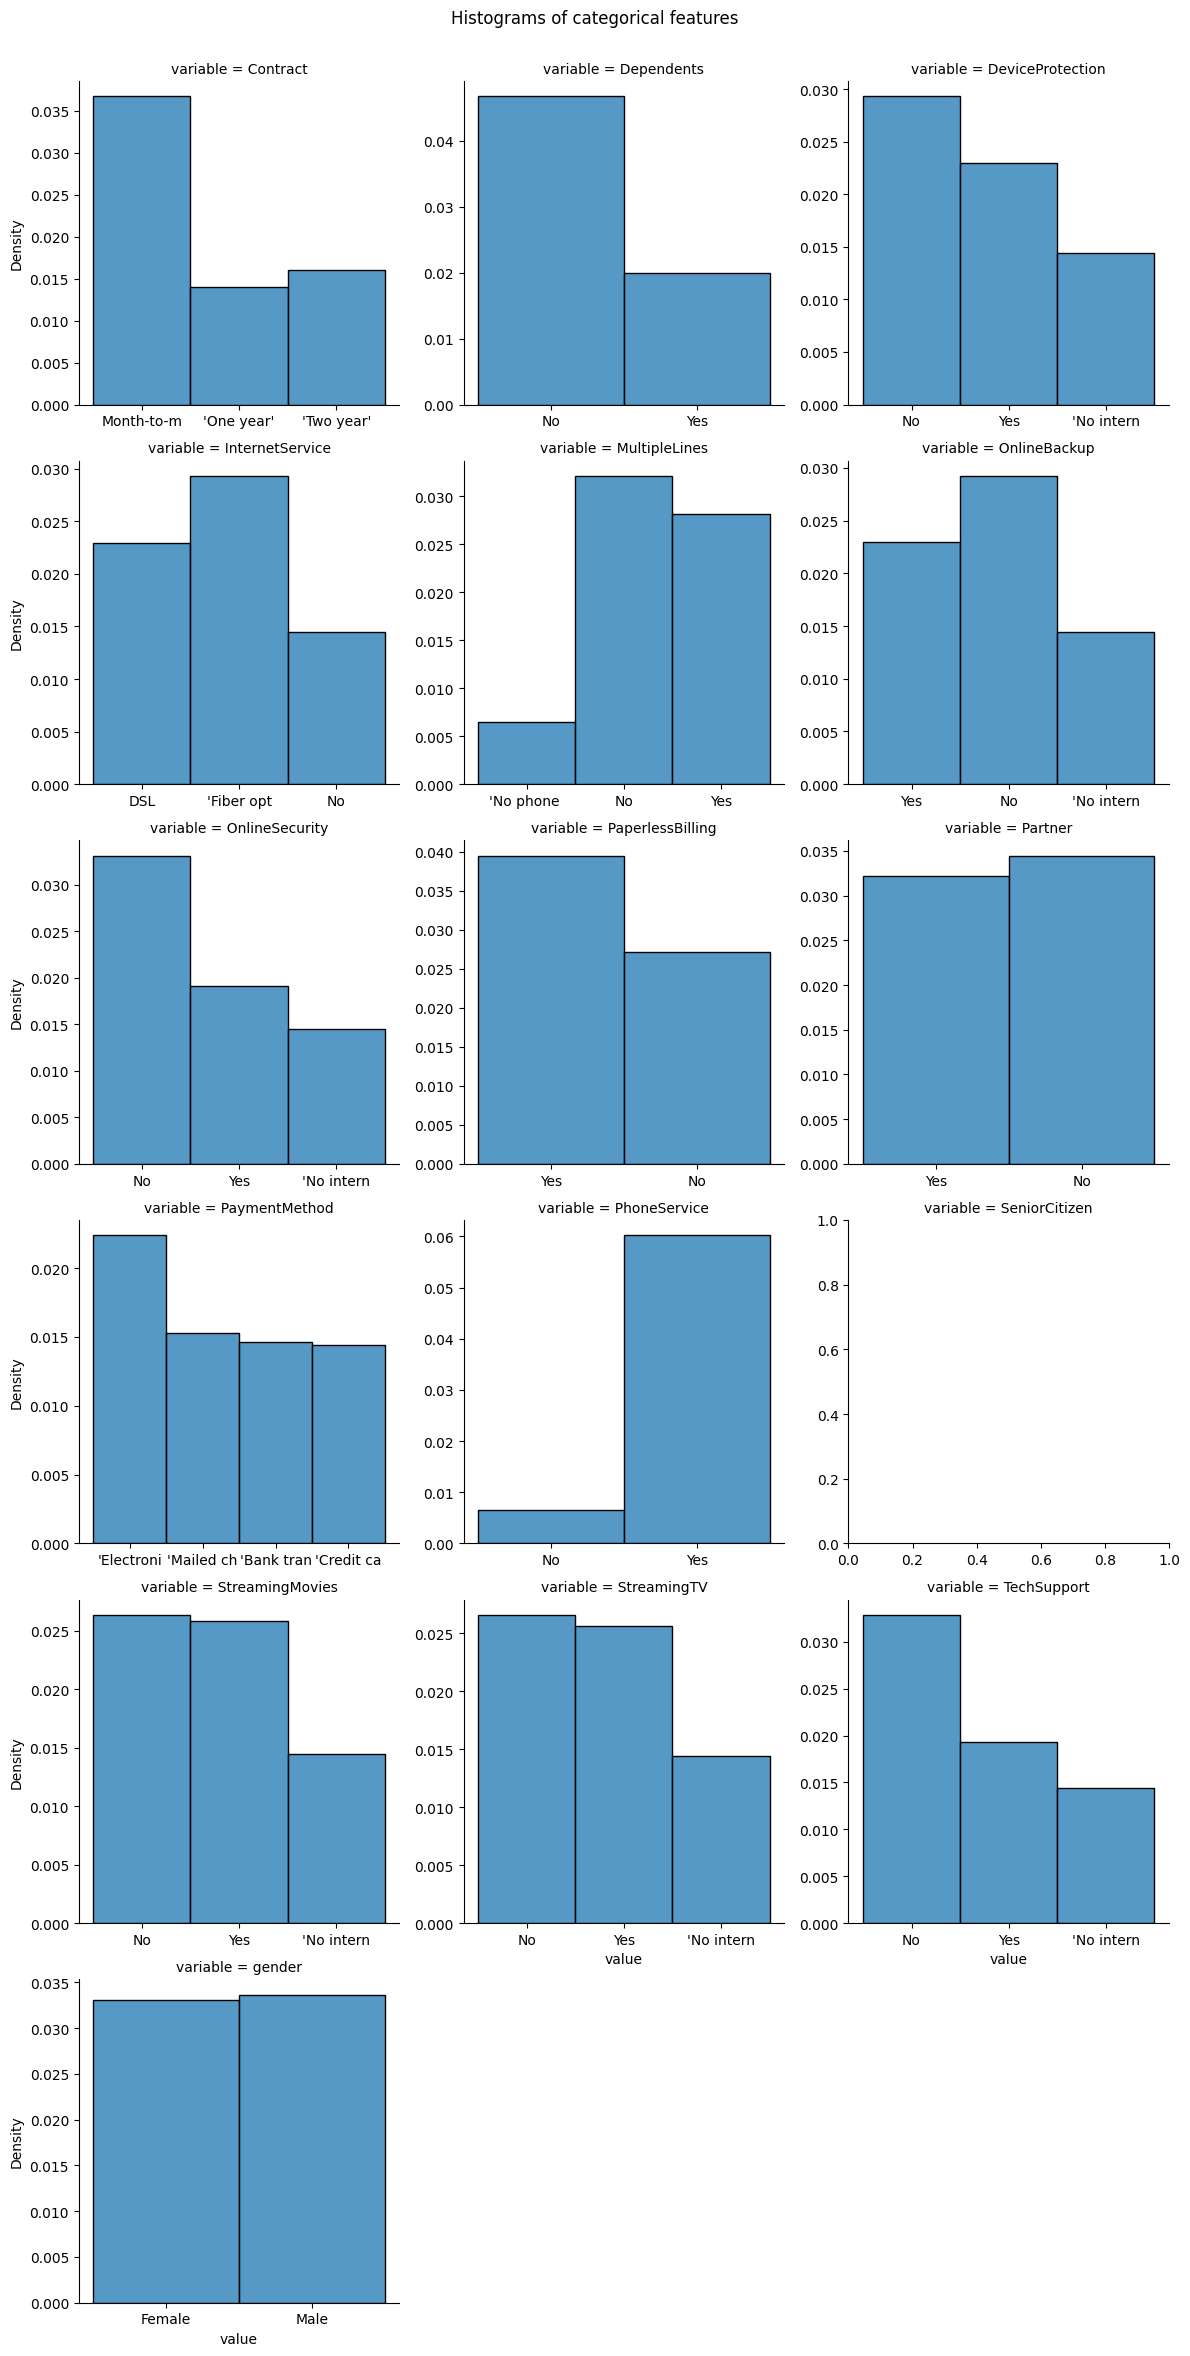

In [ ]:
g = sns.displot(
    pd.melt(df.loc[:, x_discrete]).assign(value=lambda x: x["value"].str.slice(0, 10)),
    x="value",
    col="variable",
    stat="density",
    bins=19,
    common_bins=False,
    col_wrap=3,
    height=4,
    facet_kws={"sharex": False, "sharey": False},
)
g.figure.subplots_adjust(top=0.95)
g.figure.suptitle("Histograms of categorical features")

#### 3.3.3 Correlations across continuous covariates

<Axes: >

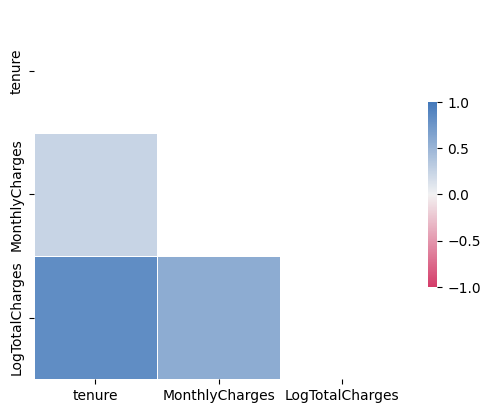

In [ ]:
corr = df.loc[:, x_continuous].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask=mask,
    vmin=-1.0,
    vmax=1.0,
    center=0,
    cmap=sns.diverging_palette(360, 250, as_cmap=True),
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)

#### 3.3.4 Response in dependence of covariates

Text(0.5, 0.98, 'Boxplots for categorical features')

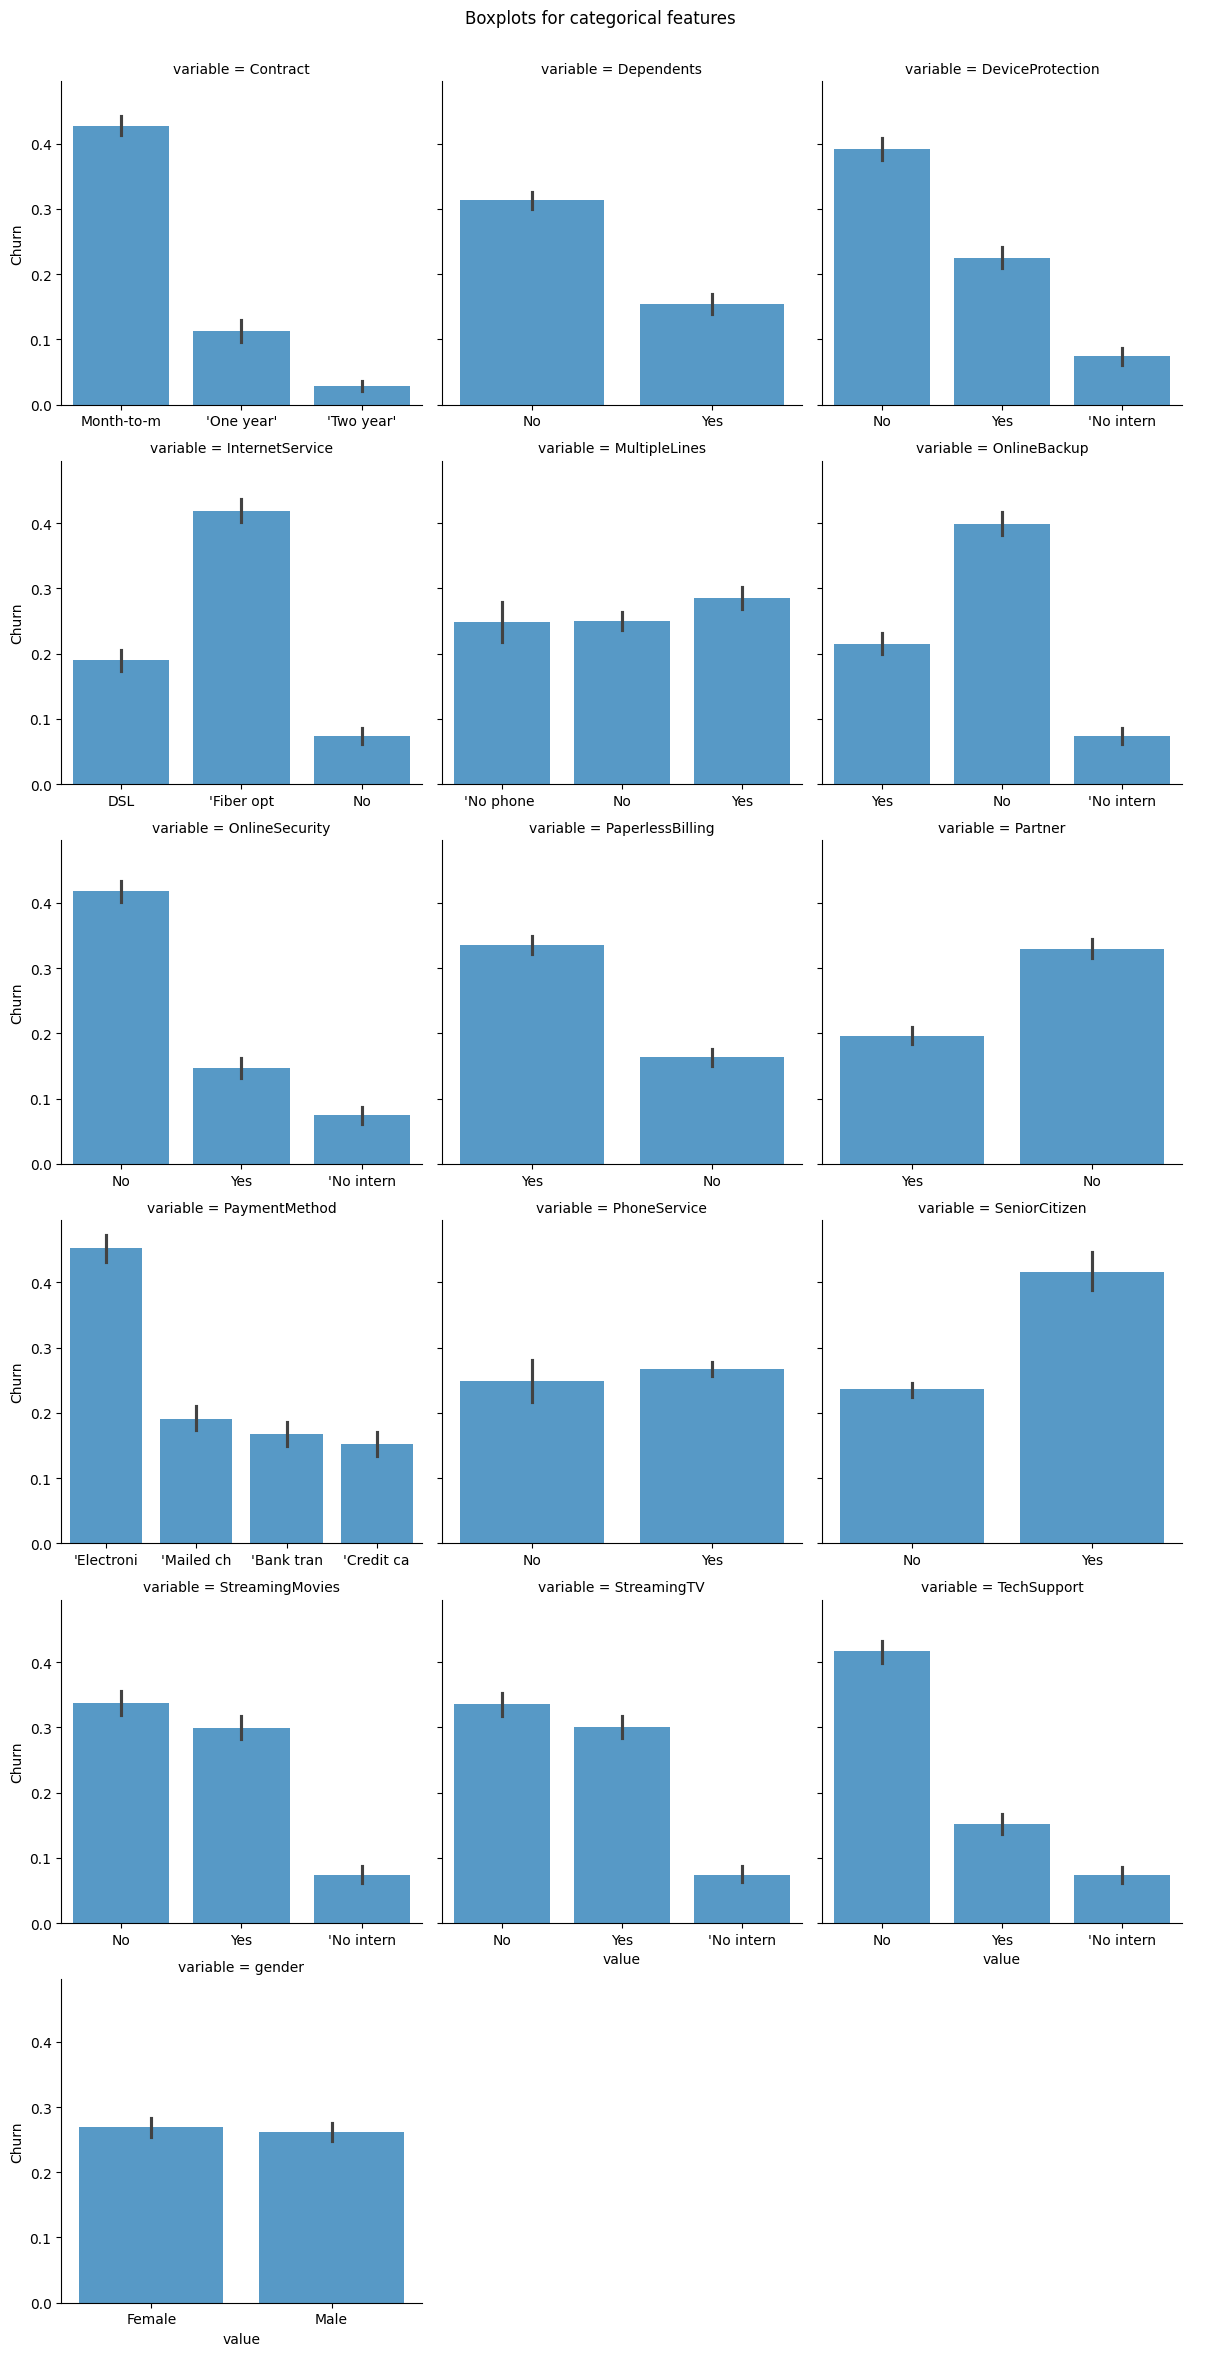

In [ ]:
g = sns.catplot(
    data=pd.melt(
        df.assign(
            Churn=lambda x: le.transform(x[y_var]),
            SeniorCitizen=lambda x: np.where(x["SeniorCitizen"], "Yes", "No"),
        ).loc[:, x_discrete + [y_var]],
        id_vars=y_var,
    ).assign(value=lambda x: x["value"].str.slice(0, 10)),
    x="value",
    y=y_var,
    col="variable",
    col_wrap=3,
    kind="bar",
    sharex=False,
    height=4,
    color="C0",
    saturation=1,
    alpha=0.75,
)
g.figure.subplots_adjust(top=0.95)
g.figure.suptitle("Boxplots for categorical features")

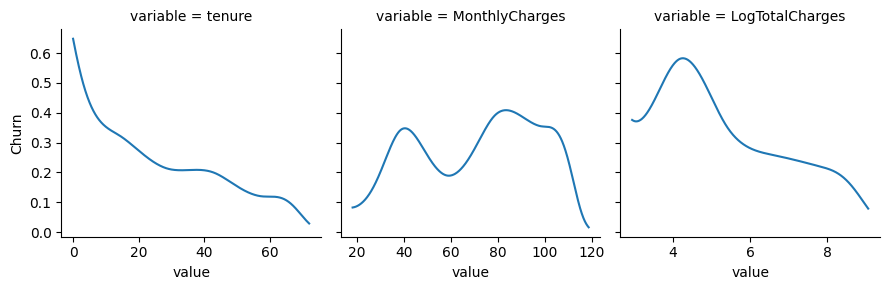

In [ ]:
# The sns.lmplot does not give satisfactory plots.
def splineplot(x, y, n_knots=10, **kwargs):
    """Logistig Regression with BSpline of polynomial order 3."""
    ax = plt.gca()
    label = kwargs.pop("label", "")
    m = Pipeline(
        [
            (
                "splines",
                SplineTransformer(
                    n_knots=n_knots, include_bias=False, sparse_output=True
                ).set_output(
                    transform="default"
                ),  # for sparse_output=True
            ),
            ("logreg", LogisticRegression(C=np.inf, solver="newton-cholesky")),
        ]
    ).fit(np.asarray(x).reshape(-1, 1), y)
    x_grid = np.linspace(x.min(), x.max(), 1000)
    ax.plot(
        x_grid,
        m.predict_proba(x_grid.reshape(-1, 1))[:, -1],
        label=f"{label} Spline".strip(),
        **kwargs,
    )


g = sns.FacetGrid(
    data=pd.melt(
        df.loc[:, x_continuous + [y_var]].assign(
            Churn=lambda x: (x["Churn"] == "Yes") * 1.0
        ),
        id_vars=y_var,
    ).dropna(),
    col="variable",
    sharex=False,
)

g.map(
    splineplot,
    "value",
    "Churn",
    n_knots=6,
)

### 3.4 Data split

Next, we split our dataset into training and test/validation data, stratified by the response.

In [ ]:
df_train, df_test = train_test_split(
    df, train_size=0.75, stratify=df[y_var], random_state=34621
)
df_all = (
    pd.concat((df_train, df_test), axis=0, keys=("train", "test"))
    .reset_index(level=0)
    .rename(columns={"level_0": "dataset"})
)

y_train, y_test = df_train[y_var], df_test[y_var]
X_train, X_test = df_train[x_vars], df_test[x_vars]

df_all.assign(Churn=lambda x: le.transform(x["Churn"])).groupby("dataset").agg(
    mean=pd.NamedAgg(column=y_var, aggfunc="mean")
)

,mean
dataset,
test,0.26519
train,0.26543


### 3.5 The models
#### 3.5.1 Trivial Model

In [ ]:
m_trivial = DummyClassifier(strategy="prior").fit(X_train, y_train)

#### 3.5.2 Logistic regression

In [ ]:
imputed_ohe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("ohe", OneHotEncoder(drop="first", sparse_output=False)),
    ]
)
m_logreg = Pipeline(
    [
        (
            "coltrans",
            ColumnTransformer(
                [
                    (
                        "numeric_features",
                        SimpleImputer(strategy="median"),
                        x_continuous,
                    ),
                    (
                        "categorical_features",
                        deepcopy(imputed_ohe),
                        x_discrete,
                    ),
                ]
            ),
        ),
        (
            "logreg",
            # Note that without penalization (large C => tiny penalty), we get:
            # LinAlgWarning: The inner solver of NewtonCholeskySolver stumbled
            # upon a singular or very ill-conditioned Hessian matrix
            LogisticRegression(C=1e8, solver="newton-cholesky"),
        ),
    ]
).fit(X_train, y_train)

#### 3.5.3 Random forest

In [ ]:
# Note that as of scikit-learn version 1.4, random forest natively support
# missing values.
m_rf = Pipeline(
    [
        (
            "coltrans",
            ColumnTransformer(
                [
                    (
                        "numeric_features",
                        "passthrough",
                        x_continuous,
                    ),
                    (
                        "categorical_features",
                        deepcopy(imputed_ohe),
                        x_discrete,
                    ),
                ]
            ),
        ),
        (
            "rf",
            RandomForestClassifier(
                min_samples_split=30,
                random_state=774,
                oob_score=log_loss,
            ),
        ),
    ]
).fit(X_train, y_train)

#### 3.5.4 XGBoost

Resonable choices for XGBoost's hyperparameters are provided in the grid search table stored as "grid/c_grid_xgb_py.csv".
Thus, there is no need for retuning those parameters.

In [ ]:
%%time

# Data interface
dtrain = xgboost.DMatrix(
    data=X_train,
    label=le.transform(y_train),
    enable_categorical=True,
)

# Settings
tune = False  # If set to True, it may take ~1h.
file_grid = "grid/c_grid_xgb_py.csv"

if tune:
    # Step 1: find good learning rate
    xgboost.cv(
        params=dict(
            learning_rate=0.01,
            tree_method="hist",
            objective="binary:logistic",
        ),
        dtrain=dtrain,
        num_boost_round=5000,
        nfold=5,
        show_stdv=False,
        early_stopping_rounds=20,
        verbose_eval=2,
    )

    # Step 2: Grid search CV on typical parameter combos
    paramGrid = dict(
        iteration=[np.nan],
        score=[np.nan],
        learning_rate=[0.01],
        max_depth=range(3, 7),
        min_child_weight=[0, 1e-04],
        colsample_bynode=[0.8, 1],
        subsample=[0.8, 1],
        reg_lambda=range(0, 3),
        reg_alpha=range(0, 3),
        objective=["binary:logistic"],
        tree_method=["hist"],
        eval_metric=["logloss"],
    )
    paramGrid = pd.DataFrame.from_records(
        itertools.product(*paramGrid.values()),
        columns=paramGrid.keys(),
    )
    for i in progress_bar(range(paramGrid.shape[0])):
        cvm = xgboost.cv(
            paramGrid.iloc[i, 2:].to_dict(),
            dtrain,
            num_boost_round=5000,
            nfold=5,
            show_stdv=False,
            early_stopping_rounds=20,
            seed=0,
            verbose_eval=0,
        )
        paramGrid.iloc[i, 0] = (bi := cvm["test-logloss-mean"].argmin()) + 1
        paramGrid.iloc[i, 1] = cvm.loc[bi, "test-logloss-mean"]
    paramGrid.sort_values("score", ascending=True).to_csv(file_grid, index=False)
paramGrid = pd.read_csv(file_grid)

CPU times: user 23.7 ms, sys: 3.82 ms, total: 27.6 ms
Wall time: 15.7 ms


In [ ]:
paramGrid.iloc[0]

iteration                     591.0
score                      0.412224
learning_rate                  0.01
max_depth                         3
min_child_weight                0.0
colsample_bynode                0.8
subsample                       0.8
reg_lambda                        0
reg_alpha                         1
objective           binary:logistic
tree_method                    hist
eval_metric                 logloss
Name: 0, dtype: object

In [ ]:
# Step 3: Fit on best params
m_xgb = xgboost.train(
    params=paramGrid.iloc[0, 2:].to_dict()
    | {"objective": "binary:logistic", "seed": 76},
    dtrain=dtrain,
    num_boost_round=int(paramGrid.iloc[0, 0]),
)


# Predict wrapper for xgb model
def m_xgb_predict(X):
    dmat = xgboost.DMatrix(X, enable_categorical=True)
    return m_xgb.predict(dmat)


# Same with bias correction
corr_fact_xgb = np.mean(le.transform(y_train)) / np.mean(m_xgb_predict(X_train))


def m_xgb_corr_predict(X):
    return corr_fact_xgb * m_xgb_predict(X)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

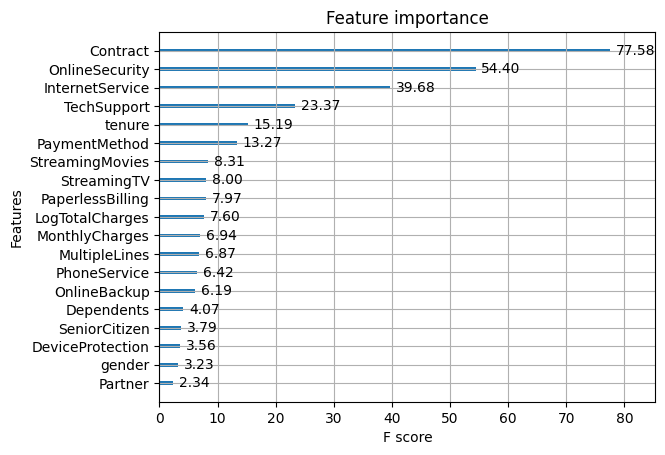

In [ ]:
# feature importance, helps to select features for calibration analysis
xgboost.plot_importance(m_xgb, importance_type="gain", values_format="{v:.2f}")

### 3.6 Calibration assessment
#### 3.6.1 Unconditional calibration in terms of bias

In [ ]:
model_levels = [
    "trivial",
    "logreg",
    "rf",
    "xgb",
    "xgb_corr",
]

df_cali = df_all.copy()
df_cali["prediction_trivial"] = m_trivial.predict_proba(df_all[x_vars])[
    :, np.flatnonzero(m_trivial.classes_ == "Yes").squeeze()
]
df_cali["prediction_logreg"] = m_logreg.predict_proba(df_all[x_vars])[
    :, np.flatnonzero(m_logreg.classes_ == "Yes").squeeze()
]
df_cali["prediction_rf"] = m_rf.predict_proba(df_all[x_vars])[
    :, np.flatnonzero(m_rf.classes_ == "Yes").squeeze()
]
df_cali["prediction_xgb"] = m_xgb_predict(df_all[x_vars])
df_cali["prediction_xgb_corr"] = m_xgb_corr_predict(df_all[x_vars])

In [ ]:
# Unconditional calibration
compute_bias(
    y_obs=le.transform(df_cali[y_var]),
    y_pred=df_cali.loc[:, df_cali.columns.str.startswith("prediction_")],
    feature=df_cali["dataset"],
).with_columns(pl.col("model").str.extract("_(\w+)", 1))

model,dataset,bias_mean,bias_count,bias_weights,bias_stderr,p_value
str,str,f64,u32,f64,f64,f64
"""trivial""","""test""",0.00024,1761,1761.0,0.010522,0.981841
"""trivial""","""train""",-1.8951e-16,5282,5282.0,0.006076,1.0
"""logreg""","""test""",-0.002567,1761,1761.0,0.008684,0.767567
"""logreg""","""train""",2.5857e-9,5282,5282.0,0.00499,1.0
"""rf""","""test""",-0.001055,1761,1761.0,0.008746,0.903983
"""rf""","""train""",0.00092,5282,5282.0,0.00463,0.842429
"""xgb""","""test""",-0.000949,1761,1761.0,0.008696,0.913076
"""xgb""","""train""",0.000412,5282,5282.0,0.004883,0.932694
"""xgb_corr""","""test""",-0.001359,1761,1761.0,0.008696,0.875803


#### 3.6.2 Reliability diagram for assessment of auto-calibration

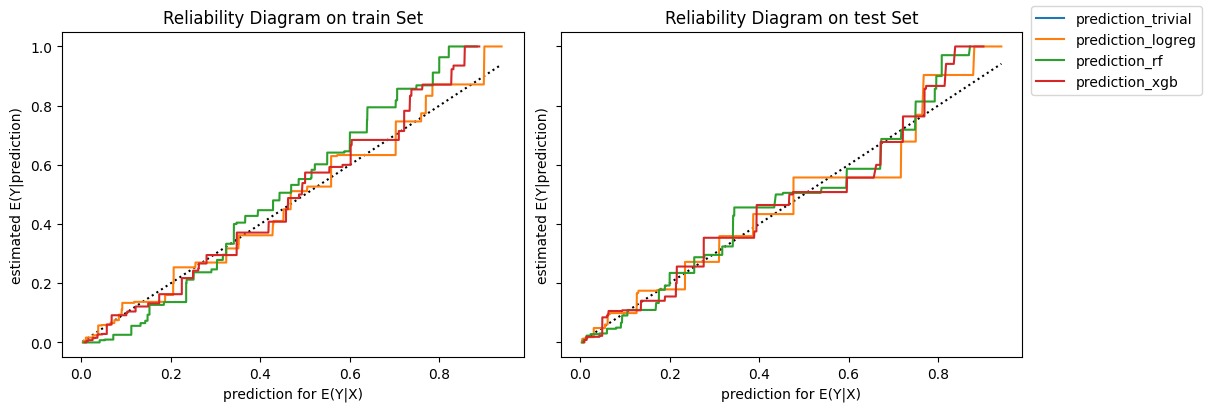

In [ ]:
fig, axes = plt.subplots(
    ncols=2, figsize=(8 + 4, 4), layout="constrained", sharey=True, sharex=True
)
for i, dataset in enumerate(["train", "test"]):
    plot_reliability_diagram(
        y_obs=le.transform(df_cali.query(f"dataset=='{dataset}'")[y_var]),
        y_pred=df_cali.query(f"dataset=='{dataset}'")
        .loc[:, df_cali.columns.str.startswith("prediction_")]
        .drop(columns="prediction_xgb_corr"),
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Reliability Diagram on {dataset} Set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")

### 3.7 Model comparison
#### 3.7.1 Compare absolute and relative performance scores

In [ ]:
results = []
for i, dataset in enumerate(["train", "test"]):
    results.append(
        decompose(
            y_obs=le.transform(df_cali.query(f"dataset=='{dataset}'")[y_var]),
            y_pred=df_cali.query(f"dataset=='{dataset}'")[
                [col for col in df_cali if col.startswith("prediction_")]
            ],
            scoring_function=LogLoss(),
        ).with_columns(dataset=pl.lit(dataset))
    )
with pl.Config(fmt_str_lengths=50):
    display(
        df_perf := pl.concat(results).select(
            pl.col("model", "dataset"), cs.all() - cs.by_name("model", "dataset")
        )
    )

model,dataset,miscalibration,discrimination,uncertainty,score
str,str,f64,f64,f64,f64
"""prediction_trivial""","""train""",0.0,0.0,0.57866,0.57866
"""prediction_logreg""","""train""",0.006178,0.179263,0.57866,0.405575
"""prediction_rf""","""train""",0.022978,0.246388,0.57866,0.355251
"""prediction_xgb""","""train""",0.007835,0.196705,0.57866,0.389789
"""prediction_xgb_corr""","""train""",0.007868,0.196705,0.57866,0.389823
"""prediction_trivial""","""test""",1.4716e-7,0.0,0.578416,0.578416
"""prediction_logreg""","""test""",0.013221,0.18099,0.578416,0.410647
"""prediction_rf""","""test""",0.011191,0.174439,0.578416,0.415168
"""prediction_xgb""","""test""",0.012883,0.180452,0.578416,0.410847


Text(0.5, 1.0, 'Mean Log Loss')

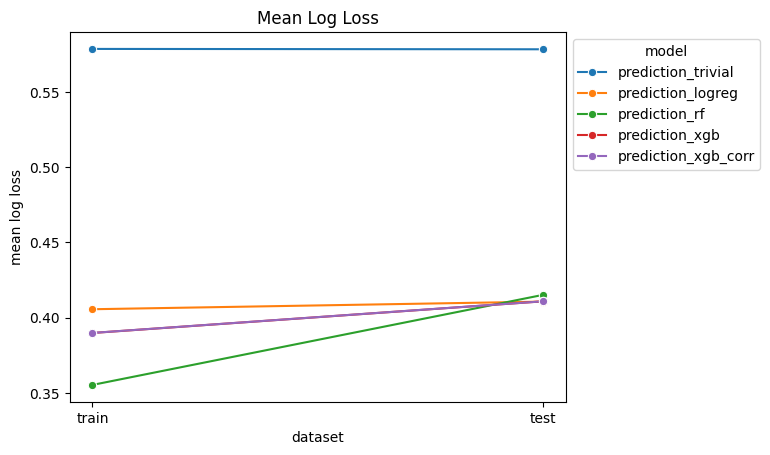

In [ ]:
ax = sns.lineplot(data=df_perf, x="dataset", y="score", hue="model", marker="o")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_ylabel("mean log loss")
ax.set_title("Mean Log Loss")

#### 3.7.2 Murphy diagram (for elementary score)

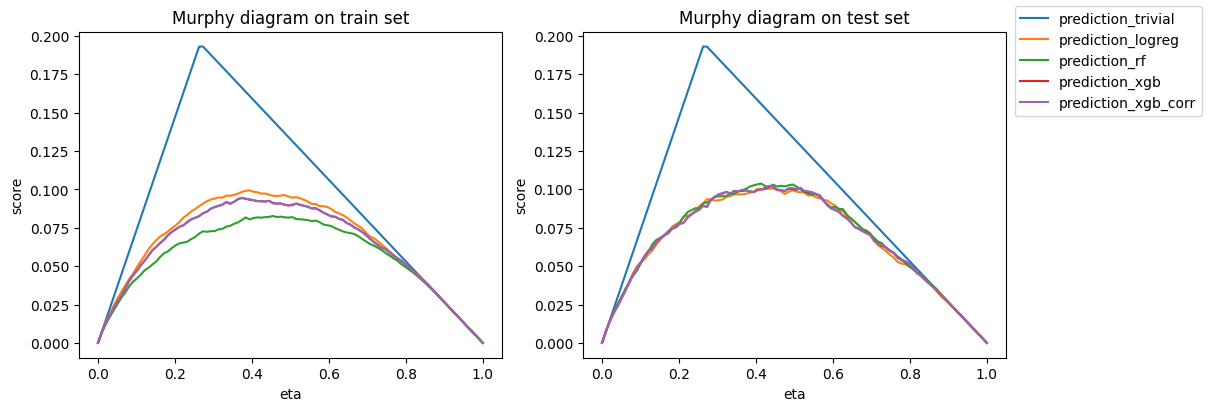

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(8 + 4, 4), layout="constrained")
for i, dataset in enumerate(["train", "test"]):
    plot_murphy_diagram(
        y_obs=le.transform(df_cali.query(f"dataset=='{dataset}'")[y_var]),
        y_pred=df_cali.query(f"dataset=='{dataset}'")[
            [
                col
                for col in df_cali
                if col.startswith("prediction_") and col not in {"trivial", "ols"}
            ]
        ],
        etas=np.linspace(0, 1, 100),
        ax=axes[i],
    )
    axes[i].legend().set_visible(False)
    axes[i].set_title(f"Murphy diagram on {dataset} set")
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc="outside right upper")